Hybrid Model Architectures:
1. Simulated Loss Architecture
2. Full Power Hybrid Model

I implemented each of these architecture with and without accumulation of loss across early exits as well.

Please note that the models are not numbered in order.

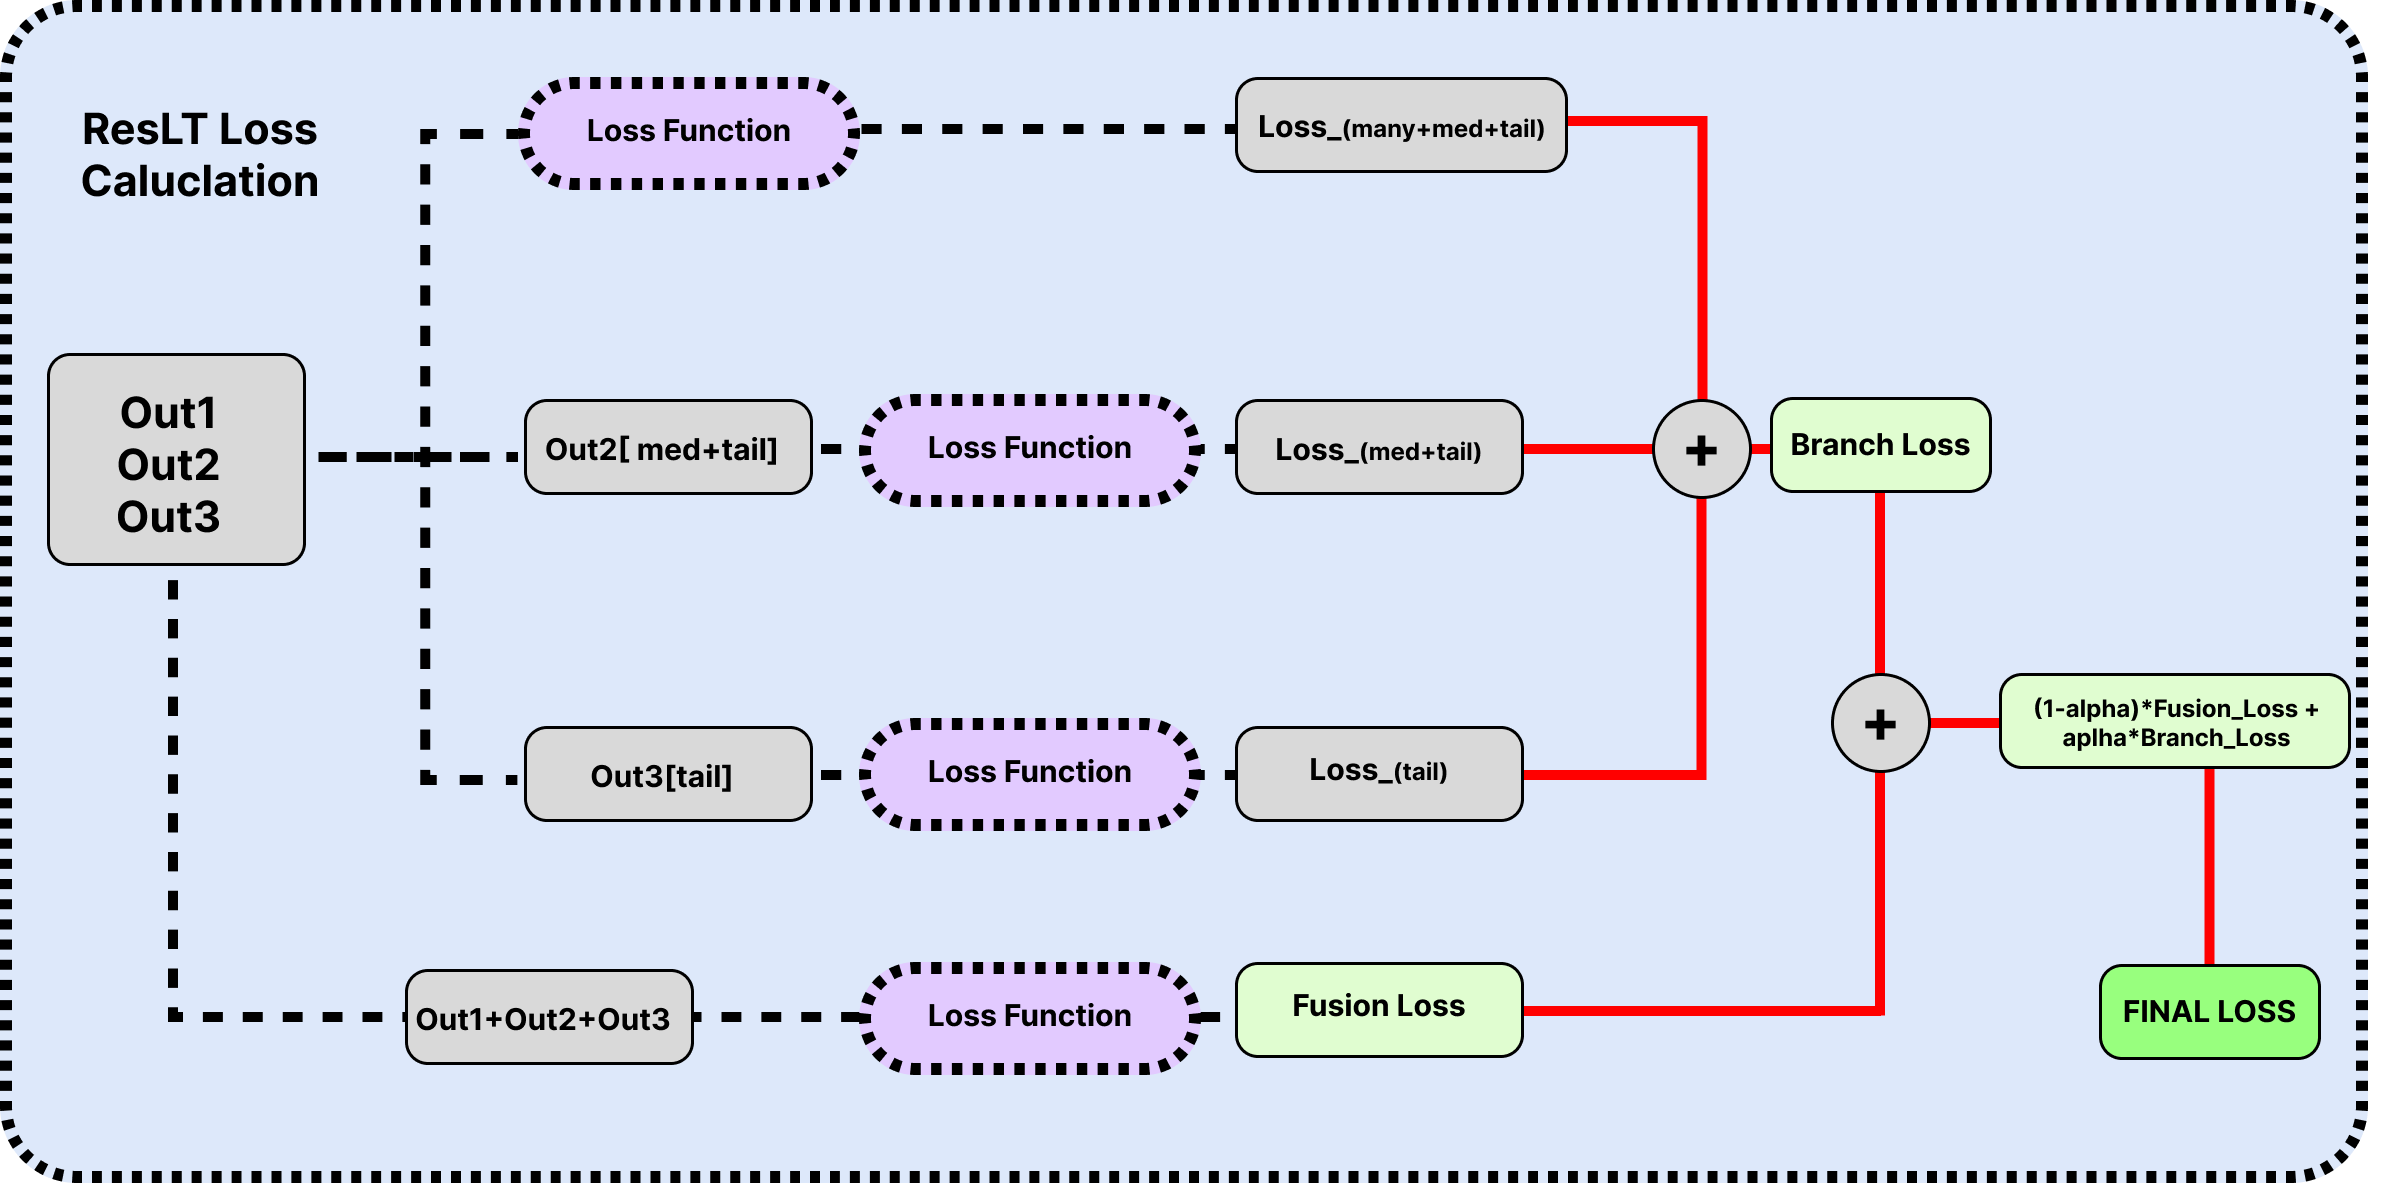

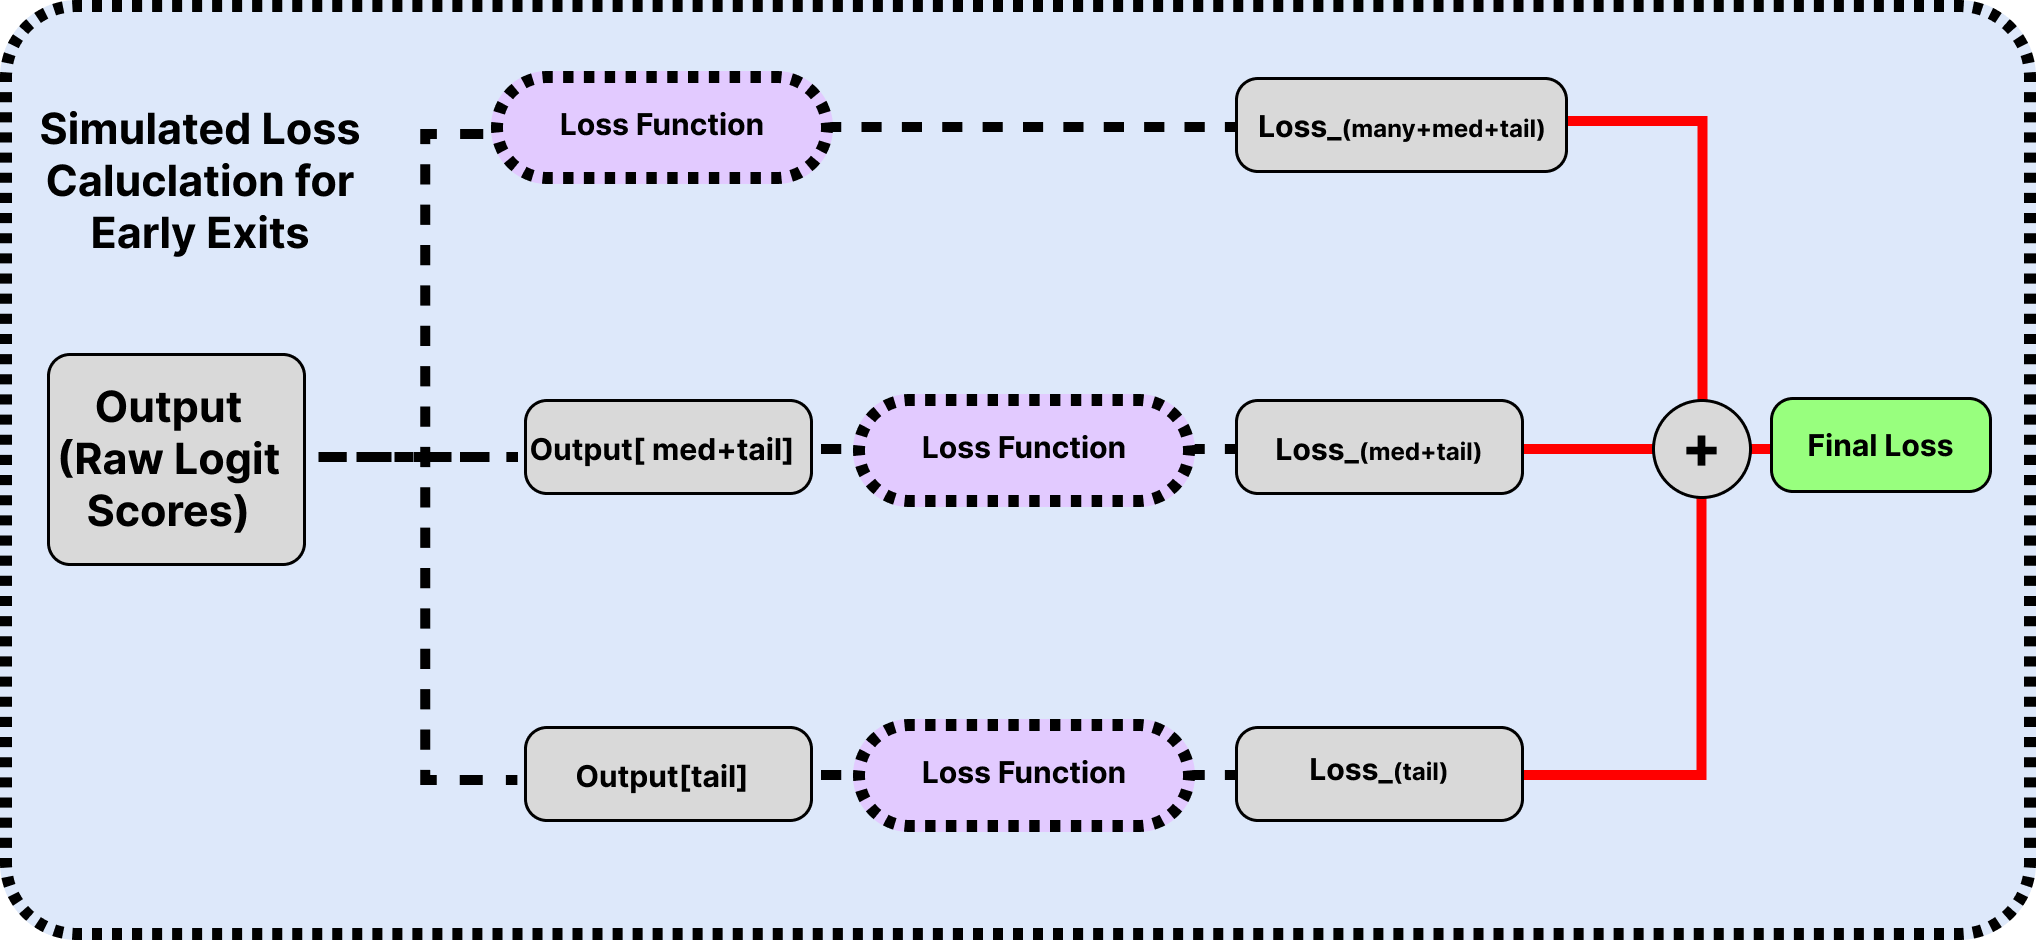

# Phase 1: Simulated Loss Architecture models with Loss Accumulation. Models[1,2,3]

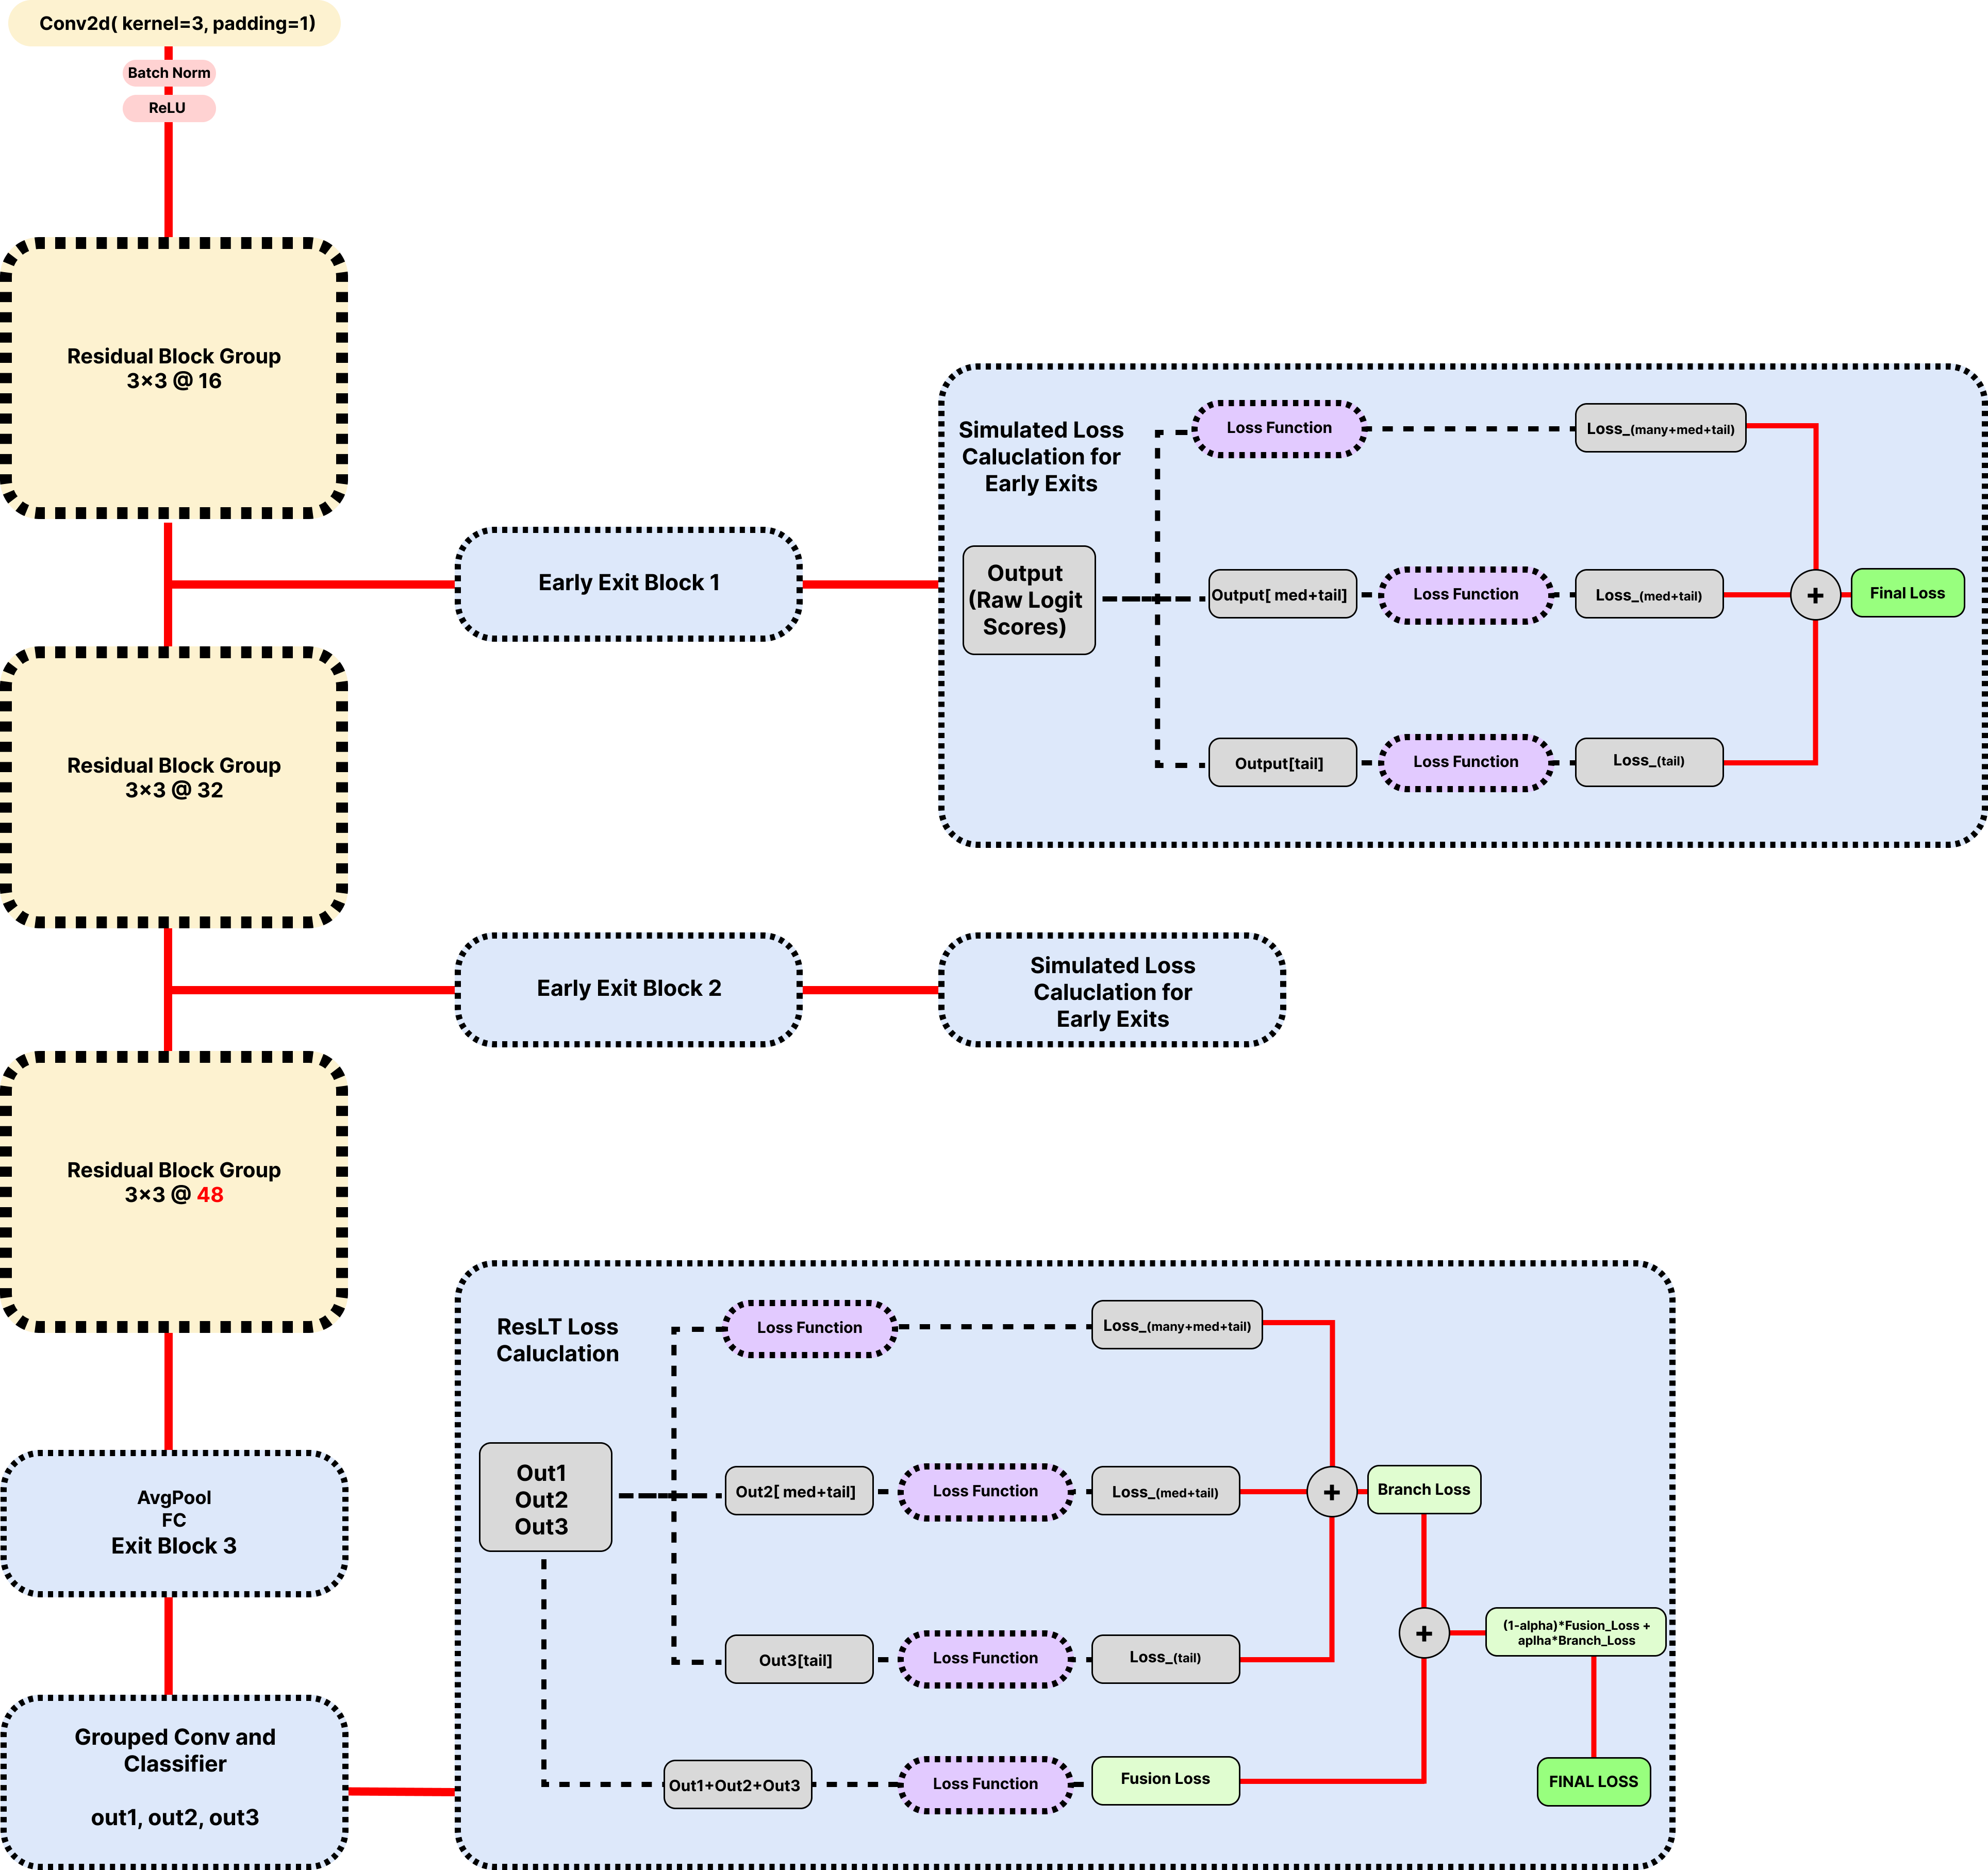

I have changed the out_channels of the last residual block group as 48 instead of 64(according to ResNet Architecture), as grouped conv requires out_channels to be a perfect multiple of 3.


The first implementation is the Simulated Loss Architecture with Cross Entropy as Loss Function.

Hybrid Model 1: Simulated Loss- Model using Cross Entropy and accumulation of Loss (Accumulative Model)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time

# =============================================================================
# CELL 1: DATASET LOADER (Using our best configuration)
# =============================================================================
def get_cifar10_lt_loaders(batch_size=128, imbalance_ratio=100, root='./data'):
    """Creates long-tailed versions of the CIFAR-10 dataset with AutoAugment."""
    mu = 1 / imbalance_ratio
    num_classes = 10
    max_per_class = 5000

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_train_dataset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    targets = np.array(full_train_dataset.targets)
    class_counts = [int(max_per_class * mu ** (i / (num_classes - 1))) for i in range(num_classes)]

    selected_indices = []
    for cls, count in enumerate(class_counts):
        cls_indices = np.where(targets == cls)[0]
        selected = np.random.choice(cls_indices, count, replace=False)
        selected_indices.extend(selected)

    train_lt_dataset = Subset(full_train_dataset, selected_indices)
    train_loader = DataLoader(train_lt_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, class_counts

# =============================================================================
# CELL 2: HYBRID MODEL ARCHITECTURE
# =============================================================================
class Hybrid_BasicBlock(nn.Module):
    """A standard ResNet basic block, to be used by the hybrid model."""
    def __init__(self, in_channels, out_channels, stride=1):
        super(Hybrid_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        return self.relu(out)

class Hybrid_ELF_ResLT(nn.Module):
    """The hybrid model combining an ELF backbone with a final ResLT head."""
    def __init__(self, block=Hybrid_BasicBlock, num_blocks=[5, 5, 5], num_classes=10):
        super(Hybrid_ELF_ResLT, self).__init__()
        self.in_channels = 16

        # --- ELF-style Backbone ---
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        # Final backbone layer outputs 48 channels to be compatible with ResLT head
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)

        # --- Early Exits (Simple Classifiers) ---
        self.exit1 = self._make_early_exit(16, num_classes)
        self.exit2 = self._make_early_exit(32, num_classes)

        # --- Final ResLT Head ---
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        num_final_features = 48
        self.group_conv = nn.Conv2d(num_final_features, num_final_features * 3, kernel_size=1, groups=3, bias=False)
        self.classifier = nn.Linear(num_final_features, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        # Downsampling is handled in the first block of the layer
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def _make_early_exit(self, in_channels, num_classes):
        # A simple classifier for early exits
        return nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_channels, num_classes)
        )

    def forward(self, x):
        # The forward pass returns all possible outputs.
        # The training loop will decide which ones to use for loss calculation.
        all_outputs = []

        out = self.relu(self.bn1(self.conv1(x)))

        # --- Path to Early Exit 1 ---
        out = self.layer1(out)
        early_out1 = self.exit1(out)
        all_outputs.append(early_out1)

        # --- Path to Early Exit 2 ---
        out = self.layer2(out)
        early_out2 = self.exit2(out)
        all_outputs.append(early_out2)

        # --- Path to Final ResLT Head ---
        out = self.layer3(out)
        out = self.avgpool(out)
        features = out.view(out.size(0), -1)
        features_2d = features.view(features.size(0), -1, 1, 1)
        grouped_features = self.group_conv(features_2d)
        grouped_features = grouped_features.view(grouped_features.size(0), 3, -1)

        branch1_feats = grouped_features[:, 0, :]
        branch2_feats = grouped_features[:, 1, :]
        branch3_feats = grouped_features[:, 2, :]

        reslt_out1 = self.classifier(branch1_feats)
        reslt_out2 = self.classifier(branch2_feats)
        reslt_out3 = self.classifier(branch3_feats)

        # The final output is a tuple containing the three branch outputs
        all_outputs.append((reslt_out1, reslt_out2, reslt_out3))

        return all_outputs

# =============================================================================
# CELL 3: TRAINING AND EVALUATION SCRIPT
# =============================================================================

def calculate_simulated_reslt_loss(output, labels, criterion, class_splits, device):
    """Calculates the efficient, 'simulated' ResLT loss for an early exit."""
    many_shot, medium_shot, few_shot = class_splits['many'], class_splits['medium'], class_splits['few']

    # The loss for each sample is calculated individually for accumulation
    loss_per_sample = criterion(output, labels)

    medium_tail_mask = torch.isin(labels, torch.tensor(medium_shot + few_shot).to(device))
    tail_mask = torch.isin(labels, torch.tensor(few_shot).to(device))

    # Add extra loss for medium/tail and tail-only samples
    loss_per_sample[medium_tail_mask] += criterion(output[medium_tail_mask], labels[medium_tail_mask])
    loss_per_sample[tail_mask] += criterion(output[tail_mask], labels[tail_mask])

    return loss_per_sample

def calculate_full_reslt_loss(outputs, labels, criterion, alpha, class_splits, device):
    """Calculates the full, original ResLT loss for the final exit."""
    out1, out2, out3 = outputs

    loss_fusion = criterion(out1 + out2 + out3, labels)

    many_shot, medium_shot, few_shot = class_splits['many'], class_splits['medium'], class_splits['few']
    loss_branch1 = criterion(out1, labels)
    medium_tail_mask = torch.isin(labels, torch.tensor(medium_shot + few_shot).to(device))
    tail_mask = torch.isin(labels, torch.tensor(few_shot).to(device))

    loss_branch2 = torch.zeros_like(loss_branch1)
    if medium_tail_mask.sum() > 0:
        loss_branch2[medium_tail_mask] = criterion(out2[medium_tail_mask], labels[medium_tail_mask])

    loss_branch3 = torch.zeros_like(loss_branch1)
    if tail_mask.sum() > 0:
        loss_branch3[tail_mask] = criterion(out3[tail_mask], labels[tail_mask])

    loss_branch = loss_branch1 + loss_branch2 + loss_branch3

    return (1 - alpha) * loss_fusion + alpha * loss_branch

def train_hybrid(model, train_loader, optimizer, criterion, alpha, class_splits, exit_threshold, device):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        all_outputs = model(images)
        batch_size = labels.size(0)
        per_sample_loss = torch.zeros(batch_size).to(device)
        has_exited = torch.zeros(batch_size, dtype=torch.bool).to(device)

        # Process early exits
        for i in range(len(all_outputs) - 1):
            output = all_outputs[i]

            # Ensure criterion returns per-sample loss
            criterion.reduction = 'none'
            loss_component = calculate_simulated_reslt_loss(output, labels, criterion, class_splits, device)
            per_sample_loss += loss_component * (~has_exited).float()

            # Check exit criterion
            probs = F.softmax(output, dim=1)
            confs, preds = torch.max(probs, dim=1)
            exited_now = (preds == labels) & (confs > exit_threshold)
            has_exited = has_exited | exited_now

            if has_exited.all(): break

        # Process final ResLT head for samples that remain
        if not has_exited.all():
            final_outputs = all_outputs[-1]
            criterion.reduction = 'none'
            loss_component = calculate_full_reslt_loss(final_outputs, labels, criterion, alpha, class_splits, device)
            per_sample_loss += loss_component * (~has_exited).float()

        final_loss = per_sample_loss.mean()
        final_loss.backward()
        optimizer.step()
        total_loss += final_loss.item()

    return total_loss / len(train_loader)

def evaluate_hybrid(model, data_loader, class_splits, inference_threshold, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            all_outputs = model(images)

            early_exit_preds = [torch.max(F.softmax(out, dim=1), 1)[1] for out in all_outputs[:-1]]
            confidences = [torch.max(F.softmax(out, dim=1), 1)[0] for out in all_outputs[:-1]]

            final_out1, final_out2, final_out3 = all_outputs[-1]
            final_preds = torch.max(final_out1 + final_out2 + final_out3, 1)[1]

            final_prediction = torch.zeros_like(labels)
            exited_mask = torch.zeros_like(labels, dtype=torch.bool)

            for i in range(len(early_exit_preds)):
                exit_now_mask = (confidences[i] > inference_threshold) & (~exited_mask)
                final_prediction[exit_now_mask] = early_exit_preds[i][exit_now_mask]
                exited_mask = exited_mask | exit_now_mask

            final_prediction[~exited_mask] = final_preds[~exited_mask]

            total += labels.size(0)
            correct += (final_prediction == labels).sum().item()

    return 100 * correct / total if total > 0 else 0


def main_hybrid():
    # --- Hyperparameters ---
    NUM_EPOCHS = 200
    BATCH_SIZE = 128
    BASE_LR = 0.1
    MOMENTUM = 0.9
    ALPHA = 0.95
    IMBALANCE_RATIO = 100
    WARMUP_EPOCHS = 5
    TRAINING_EXIT_THRESHOLD = 0.9
    INFERENCE_EXIT_THRESHOLD = 0.25

    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader, class_counts = get_cifar10_lt_loaders(BATCH_SIZE, IMBALANCE_RATIO)
    class_splits = {'many': [0, 1, 2], 'medium': [3, 4, 5], 'few': [6, 7, 8, 9]}

    model = Hybrid_ELF_ResLT(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.SGD(model.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=2e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)

    # --- ADD: History dictionary ---
    history = {'train_acc': [], 'test_acc': []}

    print("--- Starting Hybrid ELF-ResLT Training ---")

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        if epoch < WARMUP_EPOCHS:
            lr = BASE_LR * (epoch + 1) / WARMUP_EPOCHS
            for param_group in optimizer.param_groups: param_group['lr'] = lr
        else:
            lr = scheduler.get_last_lr()[0]

        avg_loss = train_hybrid(model, train_loader, optimizer, criterion, ALPHA, class_splits, TRAINING_EXIT_THRESHOLD, device)

        if epoch >= WARMUP_EPOCHS: scheduler.step()

        # --- ADD: Evaluation on both train and test sets ---
        train_acc = evaluate_hybrid(model, train_loader, class_splits, INFERENCE_EXIT_THRESHOLD, device)
        test_acc = evaluate_hybrid(model, test_loader, class_splits, INFERENCE_EXIT_THRESHOLD, device)

        # --- ADD: Append to history ---
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        epoch_time = time.time() - start_time

        # --- UPDATE: Print statement ---
        print(f"Epoch {epoch+1:03d} | Time: {epoch_time:.1f}s | LR: {lr:.5f} | "
              f"Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    print("\nTraining complete.")

    # --- ADD: Save history files ---
    model_save_path = f"hybrid_elf_reslt_imbalance_{IMBALANCE_RATIO}.pth"
    torch.save(model.state_dict(), model_save_path)
    np.save(f"hybrid_train_acc_history_imbalance_{IMBALANCE_RATIO}.npy", np.array(history['train_acc']))
    np.save(f"hybrid_test_acc_history_imbalance_{IMBALANCE_RATIO}.npy", np.array(history['test_acc']))

    print(f"Model and accuracy histories saved.")

# Direct execution
main_hybrid()


100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


--- Starting Hybrid ELF-ResLT Training ---
Epoch 001 | Time: 21.0s | LR: 0.02000 | Loss: 6.7403 | Train Acc: 42.71% | Test Acc: 21.31%
Epoch 002 | Time: 18.1s | LR: 0.04000 | Loss: 6.3349 | Train Acc: 44.66% | Test Acc: 23.20%
Epoch 003 | Time: 19.6s | LR: 0.06000 | Loss: 6.0868 | Train Acc: 43.53% | Test Acc: 21.51%
Epoch 004 | Time: 18.4s | LR: 0.08000 | Loss: 5.9579 | Train Acc: 49.54% | Test Acc: 25.68%
Epoch 005 | Time: 19.5s | LR: 0.10000 | Loss: 5.8191 | Train Acc: 52.47% | Test Acc: 22.23%
Epoch 006 | Time: 18.4s | LR: 0.10000 | Loss: 5.6327 | Train Acc: 57.02% | Test Acc: 29.56%
Epoch 007 | Time: 19.4s | LR: 0.10000 | Loss: 5.4534 | Train Acc: 57.13% | Test Acc: 32.90%
Epoch 008 | Time: 18.4s | LR: 0.10000 | Loss: 5.3835 | Train Acc: 59.65% | Test Acc: 28.19%
Epoch 009 | Time: 19.6s | LR: 0.10000 | Loss: 5.3084 | Train Acc: 62.83% | Test Acc: 32.77%
Epoch 010 | Time: 18.5s | LR: 0.10000 | Loss: 5.2211 | Train Acc: 62.47% | Test Acc: 29.87%
Epoch 011 | Time: 19.7s | LR: 0.10000

This yielded me an accuracy of 56.9%, which is far from the paper's level. I implemented the same exact model, but with LDAM Loss Function.

Hybrid Model 2: Simulated Loss- Model using LDAM Loss Function and accumulation of Loss (Accumulative Model) with training threshold of 0.2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time

# =============================================================================
# CELL 1: DATASET LOADER & LOSS FUNCTIONS
# =============================================================================
def get_cifar10_lt_loaders(batch_size=128, imbalance_ratio=100, root='./data'):
    """Creates long-tailed versions of the CIFAR-10 dataset with AutoAugment."""
    mu = 1 / imbalance_ratio
    num_classes = 10
    max_per_class = 5000

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_train_dataset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    targets = np.array(full_train_dataset.targets)
    class_counts = [int(max_per_class * mu ** (i / (num_classes - 1))) for i in range(num_classes)]

    selected_indices = []
    for cls, count in enumerate(class_counts):
        cls_indices = np.where(targets == cls)[0]
        selected = np.random.choice(cls_indices, count, replace=False)
        selected_indices.extend(selected)

    train_lt_dataset = Subset(full_train_dataset, selected_indices)
    train_loader = DataLoader(train_lt_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, class_counts

class LDAMLoss(nn.Module):
    """LDAM Loss from the ELF paper, returns per-sample loss."""
    def __init__(self, class_counts, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        margins = 1.0 / np.power(class_counts, 0.25)
        self.margins = torch.tensor(margins * (max_m / np.max(margins)), dtype=torch.float)
        self.weight = weight
        self.s = s

    def forward(self, logits, labels):
        if logits.device != self.margins.device:
            self.margins = self.margins.to(logits.device)
        if self.weight is not None and self.weight.device != logits.device:
            self.weight = self.weight.to(logits.device)

        index = torch.zeros_like(logits, dtype=torch.bool)
        index.scatter_(1, labels.data.view(-1, 1), 1)

        margin_adjusted_logits = logits - self.margins[labels].unsqueeze(1) * index.float()
        return F.cross_entropy(self.s * margin_adjusted_logits, labels, weight=self.weight, reduction='none')

def get_drw_weights(epoch, class_counts, drw_start_epoch, beta=0.9999):
    """Delayed Reweighting scheduler."""
    if epoch < drw_start_epoch:
        return None
    effective_num = 1.0 - np.power(beta, class_counts)
    weights = (1.0 - beta) / effective_num
    weights = weights / np.sum(weights) * len(class_counts)
    return torch.tensor(weights, dtype=torch.float)

# =============================================================================
# CELL 2: HYBRID MODEL ARCHITECTURE
# =============================================================================
class Hybrid_BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Hybrid_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        return self.relu(out)

class Hybrid_ELF_ResLT(nn.Module):
    def __init__(self, block=Hybrid_BasicBlock, num_blocks=[5, 5, 5], num_classes=10):
        super(Hybrid_ELF_ResLT, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.exit1 = self._make_early_exit(16, num_classes)
        self.exit2 = self._make_early_exit(32, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        num_final_features = 48
        self.group_conv = nn.Conv2d(num_final_features, num_final_features * 3, kernel_size=1, groups=3, bias=False)
        self.classifier = nn.Linear(num_final_features, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def _make_early_exit(self, in_channels, num_classes):
        return nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(in_channels, num_classes))

    def forward(self, x):
        all_outputs = []
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        all_outputs.append(self.exit1(out))
        out = self.layer2(out)
        all_outputs.append(self.exit2(out))
        out = self.layer3(out)
        out = self.avgpool(out)
        features = out.view(out.size(0), -1)
        features_2d = features.view(features.size(0), -1, 1, 1)
        grouped_features = self.group_conv(features_2d).view(features.size(0), 3, -1)
        reslt_outs = (self.classifier(grouped_features[:, 0, :]),
                      self.classifier(grouped_features[:, 1, :]),
                      self.classifier(grouped_features[:, 2, :]))
        all_outputs.append(reslt_outs)
        return all_outputs

# =============================================================================
# CELL 3: TRAINING AND EVALUATION SCRIPT
# =============================================================================

def calculate_simulated_reslt_loss(output, labels, criterion, class_splits, device):
    loss_per_sample = criterion(output, labels)
    many, medium, few = class_splits['many'], class_splits['medium'], class_splits['few']
    medium_tail_mask = torch.isin(labels, torch.tensor(medium + few).to(device))
    tail_mask = torch.isin(labels, torch.tensor(few).to(device))
    if medium_tail_mask.sum() > 0:
        loss_per_sample[medium_tail_mask] += criterion(output[medium_tail_mask], labels[medium_tail_mask])
    if tail_mask.sum() > 0:
        loss_per_sample[tail_mask] += criterion(output[tail_mask], labels[tail_mask])
    return loss_per_sample

def calculate_full_reslt_loss(outputs, labels, criterion, alpha, class_splits, device):
    out1, out2, out3 = outputs
    loss_fusion = criterion(out1 + out2 + out3, labels)
    many, medium, few = class_splits['many'], class_splits['medium'], class_splits['few']
    loss_branch1 = criterion(out1, labels)
    medium_tail_mask = torch.isin(labels, torch.tensor(medium + few).to(device))
    tail_mask = torch.isin(labels, torch.tensor(few).to(device))
    loss_branch2 = torch.zeros_like(loss_branch1)
    if medium_tail_mask.sum() > 0:
        loss_branch2[medium_tail_mask] = criterion(out2[medium_tail_mask], labels[medium_tail_mask])
    loss_branch3 = torch.zeros_like(loss_branch1)
    if tail_mask.sum() > 0:
        loss_branch3[tail_mask] = criterion(out3[tail_mask], labels[tail_mask])
    loss_branch = loss_branch1 + loss_branch2 + loss_branch3
    return (1 - alpha) * loss_fusion + alpha * loss_branch

def train_hybrid(model, loader, optimizer, criterion_builder, alpha, class_splits, exit_thresh, device, epoch, drw_start, class_counts):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        drw_weights = get_drw_weights(epoch, class_counts, drw_start)
        criterion = criterion_builder(class_counts, weight=drw_weights).to(device)

        all_outputs = model(images)
        batch_size = labels.size(0)
        per_sample_loss = torch.zeros(batch_size, device=device)
        has_exited = torch.zeros(batch_size, dtype=torch.bool, device=device)

        for i in range(len(all_outputs) - 1):
            output = all_outputs[i]
            loss_component = calculate_simulated_reslt_loss(output, labels, criterion, class_splits, device)
            per_sample_loss += loss_component * (~has_exited).float()
            probs = F.softmax(output, dim=1)
            confs, preds = torch.max(probs, dim=1)
            exited_now = (preds == labels) & (confs > exit_thresh)
            has_exited |= exited_now
            if has_exited.all(): break

        if not has_exited.all():
            final_outputs = all_outputs[-1]
            loss_component = calculate_full_reslt_loss(final_outputs, labels, criterion, alpha, class_splits, device)
            per_sample_loss += loss_component * (~has_exited).float()

        final_loss = per_sample_loss.mean()
        final_loss.backward()

        # --- THIS IS THE FIX ---
        # Add gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        # ----------------------

        optimizer.step()
        total_loss += final_loss.item()
    return total_loss / len(loader)

def evaluate_hybrid(model, loader, inference_thresh, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            all_outputs = model(images)

            early_exit_preds = [torch.max(out, 1)[1] for out in all_outputs[:-1]]
            confidences = [torch.max(F.softmax(out, dim=1), 1)[0] for out in all_outputs[:-1]]
            final_out1, final_out2, final_out3 = all_outputs[-1]
            final_preds = torch.max(final_out1 + final_out2 + final_out3, 1)[1]

            final_prediction = torch.zeros_like(labels)
            exited_mask = torch.zeros_like(labels, dtype=torch.bool)
            for i in range(len(early_exit_preds)):
                exit_now_mask = (confidences[i] > inference_thresh) & (~exited_mask)
                final_prediction[exit_now_mask] = early_exit_preds[i][exit_now_mask]
                exited_mask |= exit_now_mask
            final_prediction[~exited_mask] = final_preds[~exited_mask]

            total += labels.size(0)
            correct += (final_prediction == labels).sum().item()
    return 100 * correct / total

def main_hybrid():
    # --- Hyperparameters ---
    NUM_EPOCHS, BATCH_SIZE, BASE_LR, MOMENTUM = 200, 128, 0.1, 0.9
    ALPHA, IMBALANCE_RATIO, WARMUP_EPOCHS = 0.95, 100, 5
    TRAIN_THRESH, INFER_THRESH, DRW_START = 0.2, 0.25, 160

    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader, class_counts = get_cifar10_lt_loaders(BATCH_SIZE, IMBALANCE_RATIO)
    class_splits = {'many': [0, 1, 2], 'medium': [3, 4, 5], 'few': [6, 7, 8, 9]}
    model = Hybrid_ELF_ResLT(num_classes=10).to(device)
    criterion_builder = LDAMLoss
    optimizer = optim.SGD(model.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=2e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)
    history = {'train_acc': [], 'test_acc': []}

    print("--- Starting Hybrid ELF-ResLT Training with LDAM Loss ---")
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        if epoch < WARMUP_EPOCHS:
            lr = BASE_LR * (epoch + 1) / WARMUP_EPOCHS
            for pg in optimizer.param_groups: pg['lr'] = lr
        else:
            lr = scheduler.get_last_lr()[0]

        avg_loss = train_hybrid(model, train_loader, optimizer, criterion_builder, ALPHA, class_splits, TRAIN_THRESH, device, epoch, DRW_START, class_counts)
        if epoch >= WARMUP_EPOCHS: scheduler.step()

        train_acc = evaluate_hybrid(model, train_loader, INFER_THRESH, device)
        test_acc = evaluate_hybrid(model, test_loader, INFER_THRESH, device)
        history['train_acc'].append(train_acc); history['test_acc'].append(test_acc)

        print(f"Epoch {epoch+1:03d} | Time: {time.time()-start_time:.1f}s | LR: {lr:.5f} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    print("\nTraining complete.")
    save_path = f"hybrid_elf_reslt_ldam_imbalance_{IMBALANCE_RATIO}.pth"
    torch.save(model.state_dict(), save_path)
    for key, values in history.items(): np.save(f"hybrid_{key}_ldam_imbalance_{IMBALANCE_RATIO}.npy", np.array(values))
    print(f"Model and histories saved.")

# Direct execution
main_hybrid()


100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


--- Starting Hybrid ELF-ResLT Training with LDAM Loss ---
Epoch 001 | Time: 21.0s | LR: 0.02000 | Loss: 38.6208 | Train Acc: 11.36% | Test Acc: 11.19%
Epoch 002 | Time: 18.4s | LR: 0.04000 | Loss: 33.0916 | Train Acc: 5.16% | Test Acc: 11.86%
Epoch 003 | Time: 18.1s | LR: 0.06000 | Loss: 33.8165 | Train Acc: 37.01% | Test Acc: 14.50%
Epoch 004 | Time: 19.9s | LR: 0.08000 | Loss: 34.4955 | Train Acc: 31.52% | Test Acc: 13.84%
Epoch 005 | Time: 18.4s | LR: 0.10000 | Loss: 38.2073 | Train Acc: 14.61% | Test Acc: 13.13%
Epoch 006 | Time: 18.8s | LR: 0.10000 | Loss: 38.5384 | Train Acc: 16.99% | Test Acc: 11.84%
Epoch 007 | Time: 18.2s | LR: 0.10000 | Loss: 36.6385 | Train Acc: 27.59% | Test Acc: 17.29%
Epoch 008 | Time: 19.2s | LR: 0.10000 | Loss: 35.3768 | Train Acc: 33.41% | Test Acc: 23.33%
Epoch 009 | Time: 18.2s | LR: 0.10000 | Loss: 34.7689 | Train Acc: 43.56% | Test Acc: 14.20%
Epoch 010 | Time: 19.4s | LR: 0.10000 | Loss: 33.9160 | Train Acc: 14.40% | Test Acc: 20.97%
Epoch 011 | T

I retried the same (Model 2) but with a higher training threshold of 0.8. We need to force more samples to be considered "hard" so they can be processed by the final ResLT head.

Hybrid Model 3: Simulated Loss- Model using LDAM Loss Function and accumulation of Loss (Accumulative Model) with training threshold of 0.8

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time

# =============================================================================
# CELL 1: DATASET LOADER & LOSS FUNCTIONS
# =============================================================================
def get_cifar10_lt_loaders(batch_size=128, imbalance_ratio=100, root='./data'):
    """Creates long-tailed versions of the CIFAR-10 dataset with AutoAugment."""
    mu = 1 / imbalance_ratio
    num_classes = 10
    max_per_class = 5000

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_train_dataset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    targets = np.array(full_train_dataset.targets)
    class_counts = [int(max_per_class * mu ** (i / (num_classes - 1))) for i in range(num_classes)]

    selected_indices = []
    for cls, count in enumerate(class_counts):
        cls_indices = np.where(targets == cls)[0]
        selected = np.random.choice(cls_indices, count, replace=False)
        selected_indices.extend(selected)

    train_lt_dataset = Subset(full_train_dataset, selected_indices)
    train_loader = DataLoader(train_lt_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, class_counts

class LDAMLoss(nn.Module):
    """LDAM Loss from the ELF paper, returns per-sample loss."""
    def __init__(self, class_counts, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        margins = 1.0 / np.power(class_counts, 0.25)
        self.margins = torch.tensor(margins * (max_m / np.max(margins)), dtype=torch.float)
        self.weight = weight
        self.s = s

    def forward(self, logits, labels):
        if logits.device != self.margins.device:
            self.margins = self.margins.to(logits.device)
        if self.weight is not None and self.weight.device != logits.device:
            self.weight = self.weight.to(logits.device)

        index = torch.zeros_like(logits, dtype=torch.bool)
        index.scatter_(1, labels.data.view(-1, 1), 1)

        margin_adjusted_logits = logits - self.margins[labels].unsqueeze(1) * index.float()
        return F.cross_entropy(self.s * margin_adjusted_logits, labels, weight=self.weight, reduction='none')

def get_drw_weights(epoch, class_counts, drw_start_epoch, beta=0.9999):
    """Delayed Reweighting scheduler."""
    if epoch < drw_start_epoch:
        return None
    effective_num = 1.0 - np.power(beta, class_counts)
    weights = (1.0 - beta) / effective_num
    weights = weights / np.sum(weights) * len(class_counts)
    return torch.tensor(weights, dtype=torch.float)

# =============================================================================
# CELL 2: HYBRID MODEL ARCHITECTURE
# =============================================================================
class Hybrid_BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Hybrid_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        return self.relu(out)

class Hybrid_ELF_ResLT(nn.Module):
    def __init__(self, block=Hybrid_BasicBlock, num_blocks=[5, 5, 5], num_classes=10):
        super(Hybrid_ELF_ResLT, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.exit1 = self._make_early_exit(16, num_classes)
        self.exit2 = self._make_early_exit(32, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        num_final_features = 48
        self.group_conv = nn.Conv2d(num_final_features, num_final_features * 3, kernel_size=1, groups=3, bias=False)
        self.classifier = nn.Linear(num_final_features, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def _make_early_exit(self, in_channels, num_classes):
        return nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(in_channels, num_classes))

    def forward(self, x):
        all_outputs = []
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        all_outputs.append(self.exit1(out))
        out = self.layer2(out)
        all_outputs.append(self.exit2(out))
        out = self.layer3(out)
        out = self.avgpool(out)
        features = out.view(out.size(0), -1)
        features_2d = features.view(features.size(0), -1, 1, 1)
        grouped_features = self.group_conv(features_2d).view(features.size(0), 3, -1)
        reslt_outs = (self.classifier(grouped_features[:, 0, :]),
                      self.classifier(grouped_features[:, 1, :]),
                      self.classifier(grouped_features[:, 2, :]))
        all_outputs.append(reslt_outs)
        return all_outputs

# =============================================================================
# CELL 3: TRAINING AND EVALUATION SCRIPT
# =============================================================================

def calculate_simulated_reslt_loss(output, labels, criterion, class_splits, device):
    loss_per_sample = criterion(output, labels)
    many, medium, few = class_splits['many'], class_splits['medium'], class_splits['few']
    medium_tail_mask = torch.isin(labels, torch.tensor(medium + few).to(device))
    tail_mask = torch.isin(labels, torch.tensor(few).to(device))
    if medium_tail_mask.sum() > 0:
        loss_per_sample[medium_tail_mask] += criterion(output[medium_tail_mask], labels[medium_tail_mask])
    if tail_mask.sum() > 0:
        loss_per_sample[tail_mask] += criterion(output[tail_mask], labels[tail_mask])
    return loss_per_sample

def calculate_full_reslt_loss(outputs, labels, criterion, alpha, class_splits, device):
    out1, out2, out3 = outputs
    loss_fusion = criterion(out1 + out2 + out3, labels)
    many, medium, few = class_splits['many'], class_splits['medium'], class_splits['few']
    loss_branch1 = criterion(out1, labels)
    medium_tail_mask = torch.isin(labels, torch.tensor(medium + few).to(device))
    tail_mask = torch.isin(labels, torch.tensor(few).to(device))
    loss_branch2 = torch.zeros_like(loss_branch1)
    if medium_tail_mask.sum() > 0:
        loss_branch2[medium_tail_mask] = criterion(out2[medium_tail_mask], labels[medium_tail_mask])
    loss_branch3 = torch.zeros_like(loss_branch1)
    if tail_mask.sum() > 0:
        loss_branch3[tail_mask] = criterion(out3[tail_mask], labels[tail_mask])
    loss_branch = loss_branch1 + loss_branch2 + loss_branch3
    return (1 - alpha) * loss_fusion + alpha * loss_branch

def train_hybrid(model, loader, optimizer, criterion_builder, alpha, class_splits, exit_thresh, device, epoch, drw_start, class_counts):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        drw_weights = get_drw_weights(epoch, class_counts, drw_start)
        criterion = criterion_builder(class_counts, weight=drw_weights).to(device)

        all_outputs = model(images)
        batch_size = labels.size(0)
        per_sample_loss = torch.zeros(batch_size, device=device)
        has_exited = torch.zeros(batch_size, dtype=torch.bool, device=device)

        for i in range(len(all_outputs) - 1):
            output = all_outputs[i]
            loss_component = calculate_simulated_reslt_loss(output, labels, criterion, class_splits, device)
            per_sample_loss += loss_component * (~has_exited).float()
            probs = F.softmax(output, dim=1)
            confs, preds = torch.max(probs, dim=1)
            exited_now = (preds == labels) & (confs > exit_thresh)
            has_exited |= exited_now
            if has_exited.all(): break

        if not has_exited.all():
            final_outputs = all_outputs[-1]
            loss_component = calculate_full_reslt_loss(final_outputs, labels, criterion, alpha, class_splits, device)
            per_sample_loss += loss_component * (~has_exited).float()

        final_loss = per_sample_loss.mean()
        final_loss.backward()

        # --- THIS IS THE FIX ---
        # Add gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        # ----------------------

        optimizer.step()
        total_loss += final_loss.item()
    return total_loss / len(loader)

def evaluate_hybrid(model, loader, inference_thresh, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            all_outputs = model(images)

            early_exit_preds = [torch.max(out, 1)[1] for out in all_outputs[:-1]]
            confidences = [torch.max(F.softmax(out, dim=1), 1)[0] for out in all_outputs[:-1]]
            final_out1, final_out2, final_out3 = all_outputs[-1]
            final_preds = torch.max(final_out1 + final_out2 + final_out3, 1)[1]

            final_prediction = torch.zeros_like(labels)
            exited_mask = torch.zeros_like(labels, dtype=torch.bool)
            for i in range(len(early_exit_preds)):
                exit_now_mask = (confidences[i] > inference_thresh) & (~exited_mask)
                final_prediction[exit_now_mask] = early_exit_preds[i][exit_now_mask]
                exited_mask |= exit_now_mask
            final_prediction[~exited_mask] = final_preds[~exited_mask]

            total += labels.size(0)
            correct += (final_prediction == labels).sum().item()
    return 100 * correct / total

def main_hybrid():
    # --- Hyperparameters ---
    NUM_EPOCHS, BATCH_SIZE, BASE_LR, MOMENTUM = 200, 128, 0.1, 0.9
    ALPHA, IMBALANCE_RATIO, WARMUP_EPOCHS = 0.95, 100, 5
    TRAIN_THRESH, INFER_THRESH, DRW_START = 0.8, 0.25, 160

    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader, class_counts = get_cifar10_lt_loaders(BATCH_SIZE, IMBALANCE_RATIO)
    class_splits = {'many': [0, 1, 2], 'medium': [3, 4, 5], 'few': [6, 7, 8, 9]}
    model = Hybrid_ELF_ResLT(num_classes=10).to(device)
    criterion_builder = LDAMLoss
    optimizer = optim.SGD(model.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=2e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)
    history = {'train_acc': [], 'test_acc': []}

    print("--- Starting Hybrid ELF-ResLT Training with LDAM Loss ---")
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        if epoch < WARMUP_EPOCHS:
            lr = BASE_LR * (epoch + 1) / WARMUP_EPOCHS
            for pg in optimizer.param_groups: pg['lr'] = lr
        else:
            lr = scheduler.get_last_lr()[0]

        avg_loss = train_hybrid(model, train_loader, optimizer, criterion_builder, ALPHA, class_splits, TRAIN_THRESH, device, epoch, DRW_START, class_counts)
        if epoch >= WARMUP_EPOCHS: scheduler.step()

        train_acc = evaluate_hybrid(model, train_loader, INFER_THRESH, device)
        test_acc = evaluate_hybrid(model, test_loader, INFER_THRESH, device)
        history['train_acc'].append(train_acc); history['test_acc'].append(test_acc)

        print(f"Epoch {epoch+1:03d} | Time: {time.time()-start_time:.1f}s | LR: {lr:.5f} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    print("\nTraining complete.")
    save_path = f"hybrid_elf_reslt_ldam_imbalance_{IMBALANCE_RATIO}.pth"
    torch.save(model.state_dict(), save_path)
    for key, values in history.items(): np.save(f"hybrid_{key}_ldam_imbalance_{IMBALANCE_RATIO}.npy", np.array(values))
    print(f"Model and histories saved.")

# Direct execution
main_hybrid()


--- Starting Hybrid ELF-ResLT Training with LDAM Loss ---
Epoch 001 | Time: 18.6s | LR: 0.02000 | Loss: 40.4242 | Train Acc: 27.32% | Test Acc: 14.06%
Epoch 002 | Time: 20.7s | LR: 0.04000 | Loss: 32.5819 | Train Acc: 14.17% | Test Acc: 13.29%
Epoch 003 | Time: 18.8s | LR: 0.06000 | Loss: 33.9121 | Train Acc: 20.97% | Test Acc: 16.71%
Epoch 004 | Time: 19.6s | LR: 0.08000 | Loss: 36.7926 | Train Acc: 7.22% | Test Acc: 18.62%
Epoch 005 | Time: 18.8s | LR: 0.10000 | Loss: 39.4856 | Train Acc: 40.54% | Test Acc: 15.56%
Epoch 006 | Time: 21.1s | LR: 0.10000 | Loss: 39.1069 | Train Acc: 13.18% | Test Acc: 12.60%
Epoch 007 | Time: 19.8s | LR: 0.10000 | Loss: 38.5965 | Train Acc: 20.38% | Test Acc: 15.50%
Epoch 008 | Time: 19.0s | LR: 0.10000 | Loss: 41.2154 | Train Acc: 32.59% | Test Acc: 22.04%
Epoch 009 | Time: 19.6s | LR: 0.10000 | Loss: 37.0042 | Train Acc: 13.08% | Test Acc: 13.13%
Epoch 010 | Time: 18.9s | LR: 0.10000 | Loss: 36.0058 | Train Acc: 35.57% | Test Acc: 20.70%
Epoch 011 | T

This yielded me an accuracy of 68.09%. 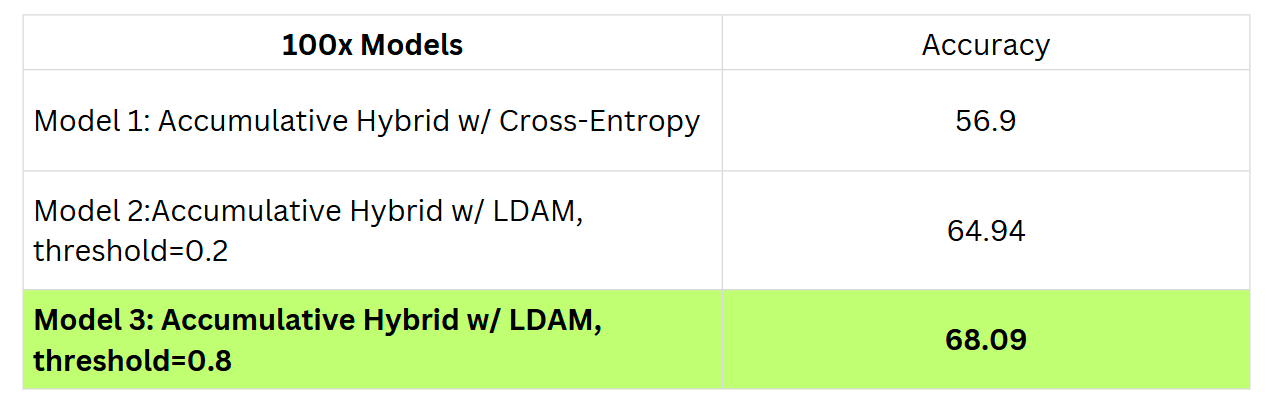

The only difference between [Model 1] and [Models 2,3] is the custom LDAM Loss defined. The code for Models 2 and 3 are the same, but with different training threshold. I have numbered models so that it is easy to navigate.

#  Phase 2 Simulated Loss Architecture without Loss Accumulation Models[4,7]

Based on the instability of the first models, I did the same but did not accumulate the losses for each sample from the previous exits. I tried this to address the complexity of the model.

I am going to route the individual loss only from the exit where exit criterion is met first, and no accumulation of loss from the previous exits is done in these models.
These models are addressed as Routed Models, where I am not accumulating Loss across exits.

Hybrid Model 4: Simulateed Loss- Routed Hybrid with LDAM Loss function

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time

# =============================================================================
# CELL 1: DATASET LOADER & LOSS FUNCTIONS
# =============================================================================
def get_cifar10_lt_loaders(batch_size=128, imbalance_ratio=100, root='./data'):
    """Creates long-tailed versions of the CIFAR-10 dataset with AutoAugment."""
    mu = 1 / imbalance_ratio
    num_classes = 10
    max_per_class = 5000

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_train_dataset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    targets = np.array(full_train_dataset.targets)
    class_counts = [int(max_per_class * mu ** (i / (num_classes - 1))) for i in range(num_classes)]

    selected_indices = []
    for cls, count in enumerate(class_counts):
        cls_indices = np.where(targets == cls)[0]
        selected = np.random.choice(cls_indices, count, replace=False)
        selected_indices.extend(selected)

    train_lt_dataset = Subset(full_train_dataset, selected_indices)
    train_loader = DataLoader(train_lt_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, class_counts

class LDAMLoss(nn.Module):
    """LDAM Loss that returns per-sample loss."""
    def __init__(self, class_counts, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        margins = 1.0 / np.power(class_counts, 0.25)
        self.margins = torch.tensor(margins * (max_m / np.max(margins)), dtype=torch.float)
        self.weight = weight
        self.s = s

    def forward(self, logits, labels):
        if logits.device != self.margins.device:
            self.margins = self.margins.to(logits.device)
        if self.weight is not None and self.weight.device != logits.device:
            self.weight = self.weight.to(logits.device)

        index = torch.zeros_like(logits, dtype=torch.bool)
        index.scatter_(1, labels.data.view(-1, 1), 1)

        margin_adjusted_logits = logits - self.margins[labels].unsqueeze(1) * index.float()
        return F.cross_entropy(self.s * margin_adjusted_logits, labels, weight=self.weight, reduction='none')

def get_drw_weights(epoch, class_counts, drw_start_epoch, beta=0.9999):
    if epoch < drw_start_epoch:
        return None
    effective_num = 1.0 - np.power(beta, class_counts)
    weights = (1.0 - beta) / effective_num
    weights = weights / np.sum(weights) * len(class_counts)
    return torch.tensor(weights, dtype=torch.float)

# =============================================================================
# CELL 2: HYBRID MODEL ARCHITECTURE (Same as before)
# =============================================================================
class Hybrid_BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Hybrid_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        return self.relu(out)

class Hybrid_Routed_Model(nn.Module):
    def __init__(self, block=Hybrid_BasicBlock, num_blocks=[5, 5, 5], num_classes=10):
        super(Hybrid_Routed_Model, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.exit1 = self._make_early_exit(16, num_classes)
        self.exit2 = self._make_early_exit(32, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        num_final_features = 48
        self.group_conv = nn.Conv2d(num_final_features, num_final_features * 3, kernel_size=1, groups=3, bias=False)
        self.classifier = nn.Linear(num_final_features, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def _make_early_exit(self, in_channels, num_classes):
        return nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(in_channels, num_classes))

    def forward(self, x):
        all_outputs = []
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        all_outputs.append(self.exit1(out))
        out = self.layer2(out)
        all_outputs.append(self.exit2(out))
        out = self.layer3(out)
        out = self.avgpool(out)
        features = out.view(out.size(0), -1)
        features_2d = features.view(features.size(0), -1, 1, 1)
        grouped_features = self.group_conv(features_2d).view(features.size(0), 3, -1)
        reslt_outs = (self.classifier(grouped_features[:, 0, :]),
                      self.classifier(grouped_features[:, 1, :]),
                      self.classifier(grouped_features[:, 2, :]))
        all_outputs.append(reslt_outs)
        return all_outputs

# =============================================================================
# CELL 3: TRAINING AND EVALUATION SCRIPT (WITH ROUTED LOSS)
# =============================================================================

def calculate_simulated_reslt_loss(output, labels, criterion, class_splits, device):
    loss_per_sample = criterion(output, labels)
    many, medium, few = class_splits['many'], class_splits['medium'], class_splits['few']
    medium_tail_mask = torch.isin(labels, torch.tensor(medium + few).to(device))
    tail_mask = torch.isin(labels, torch.tensor(few).to(device))
    if medium_tail_mask.sum() > 0:
        loss_per_sample[medium_tail_mask] += criterion(output[medium_tail_mask], labels[medium_tail_mask])
    if tail_mask.sum() > 0:
        loss_per_sample[tail_mask] += criterion(output[tail_mask], labels[tail_mask])
    return loss_per_sample

def calculate_full_reslt_loss(outputs, labels, criterion, alpha, class_splits, device):
    out1, out2, out3 = outputs
    loss_fusion = criterion(out1 + out2 + out3, labels)
    many, medium, few = class_splits['many'], class_splits['medium'], class_splits['few']
    loss_branch1 = criterion(out1, labels)
    medium_tail_mask = torch.isin(labels, torch.tensor(medium + few).to(device))
    tail_mask = torch.isin(labels, torch.tensor(few).to(device))
    loss_branch2 = torch.zeros_like(loss_branch1)
    if medium_tail_mask.sum() > 0:
        loss_branch2[medium_tail_mask] = criterion(out2[medium_tail_mask], labels[medium_tail_mask])
    loss_branch3 = torch.zeros_like(loss_branch1)
    if tail_mask.sum() > 0:
        loss_branch3[tail_mask] = criterion(out3[tail_mask], labels[tail_mask])
    loss_branch = loss_branch1 + loss_branch2 + loss_branch3
    return (1 - alpha) * loss_fusion + alpha * loss_branch

def train_routed_hybrid(model, loader, optimizer, criterion_builder, alpha, class_splits, exit_thresh, device, epoch, drw_start, class_counts):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        drw_weights = get_drw_weights(epoch, class_counts, drw_start)
        criterion = criterion_builder(class_counts, weight=drw_weights).to(device)

        all_outputs = model(images)
        batch_size = labels.size(0)
        per_sample_loss = torch.zeros(batch_size, device=device)
        has_exited = torch.zeros(batch_size, dtype=torch.bool, device=device)

        # --- ROUTED LOSS LOGIC ---
        for i in range(len(all_outputs) - 1):
            output = all_outputs[i]
            not_exited_mask = ~has_exited

            if not_exited_mask.sum() == 0: break # All samples have exited

            probs = F.softmax(output[not_exited_mask], dim=1)
            confs, preds = torch.max(probs, dim=1)
            exited_now_mask_local = (preds == labels[not_exited_mask]) & (confs > exit_thresh)

            global_indices_exiting_now = not_exited_mask.nonzero(as_tuple=True)[0][exited_now_mask_local]

            if len(global_indices_exiting_now) > 0:
                loss_component = calculate_simulated_reslt_loss(output[global_indices_exiting_now], labels[global_indices_exiting_now], criterion, class_splits, device)
                per_sample_loss[global_indices_exiting_now] = loss_component
                has_exited[global_indices_exiting_now] = True

        if not has_exited.all():
            not_exited_mask = ~has_exited
            final_outputs = (all_outputs[-1][0][not_exited_mask],
                             all_outputs[-1][1][not_exited_mask],
                             all_outputs[-1][2][not_exited_mask])

            loss_component = calculate_full_reslt_loss(final_outputs, labels[not_exited_mask], criterion, alpha, class_splits, device)
            per_sample_loss[not_exited_mask] = loss_component

        final_loss = per_sample_loss.mean()
        final_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += final_loss.item()
    return total_loss / len(loader)

def evaluate_hybrid(model, loader, class_splits, inference_thresh, device):
    model.eval()
    correct = {k: 0 for k in class_splits.keys()}
    total = {k: 0 for k in class_splits.keys()}
    correct['all'], total['all'] = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            all_outputs = model(images)

            early_exit_preds = [torch.max(out, 1)[1] for out in all_outputs[:-1]]
            confidences = [torch.max(F.softmax(out, dim=1), 1)[0] for out in all_outputs[:-1]]
            final_out1, final_out2, final_out3 = all_outputs[-1]
            final_preds = torch.max(final_out1 + final_out2 + final_out3, 1)[1]

            final_prediction = torch.zeros_like(labels)
            exited_mask = torch.zeros_like(labels, dtype=torch.bool)
            for i in range(len(early_exit_preds)):
                exit_now_mask = (confidences[i] > inference_thresh) & (~exited_mask)
                final_prediction[exit_now_mask] = early_exit_preds[i][exit_now_mask]
                exited_mask |= exit_now_mask
            final_prediction[~exited_mask] = final_preds[~exited_mask]

            # Detailed accuracy calculation
            for i in range(labels.size(0)):
                label = labels[i].item()
                pred = final_prediction[i].item()

                is_correct = (pred == label)

                total['all'] += 1
                if is_correct: correct['all'] += 1

                if label in class_splits['many']:
                    total['many'] += 1
                    if is_correct: correct['many'] += 1
                elif label in class_splits['medium']:
                    total['medium'] += 1
                    if is_correct: correct['medium'] += 1
                elif label in class_splits['few']:
                    total['few'] += 1
                    if is_correct: correct['few'] += 1

    accuracies = {k: 100 * correct[k] / total[k] if total[k] > 0 else 0 for k in total}
    return accuracies

def main_routed_hybrid():
    # --- Hyperparameters ---
    NUM_EPOCHS, BATCH_SIZE, BASE_LR, MOMENTUM = 200, 128, 0.1, 0.9
    ALPHA, IMBALANCE_RATIO, WARMUP_EPOCHS = 0.95, 100, 5
    TRAIN_THRESH, INFER_THRESH, DRW_START = 0.5, 0.5, 160

    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader, class_counts = get_cifar10_lt_loaders(BATCH_SIZE, IMBALANCE_RATIO)
    class_splits = {'many': [0, 1, 2], 'medium': [3, 4, 5], 'few': [6, 7, 8, 9]}
    model = Hybrid_Routed_Model(num_classes=10).to(device)
    criterion_builder = LDAMLoss
    optimizer = optim.SGD(model.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=2e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)
    history = {
        'train_acc': [], 'test_acc': [],
        'test_acc_many': [], 'test_acc_medium': [], 'test_acc_few': []
    }

    print("--- Starting ROUTED Hybrid ELF-ResLT Training with LDAM Loss ---")
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        if epoch < WARMUP_EPOCHS:
            lr = BASE_LR * (epoch + 1) / WARMUP_EPOCHS
            for pg in optimizer.param_groups: pg['lr'] = lr
        else:
            lr = scheduler.get_last_lr()[0]

        avg_loss = train_routed_hybrid(model, train_loader, optimizer, criterion_builder, ALPHA, class_splits, TRAIN_THRESH, device, epoch, DRW_START, class_counts)
        if epoch >= WARMUP_EPOCHS: scheduler.step()

        train_accuracies = evaluate_hybrid(model, train_loader, class_splits, INFER_THRESH, device)
        test_accuracies = evaluate_hybrid(model, test_loader, class_splits, INFER_THRESH, device)

        history['train_acc'].append(train_accuracies['all'])
        history['test_acc'].append(test_accuracies['all'])
        history['test_acc_many'].append(test_accuracies['many'])
        history['test_acc_medium'].append(test_accuracies['medium'])
        history['test_acc_few'].append(test_accuracies['few'])

        print(f"Epoch {epoch+1:03d} | Time: {time.time()-start_time:.1f}s | LR: {lr:.5f} | "
              f"Loss: {avg_loss:.4f} | Train Acc: {train_accuracies['all']:.2f}% | Test Acc: {test_accuracies['all']:.2f}% | "
              f"(Many: {test_accuracies['many']:.2f}%, Medium: {test_accuracies['medium']:.2f}%, Few: {test_accuracies['few']:.2f}%)")

    print("\nTraining complete.")
    save_path = f"routed_hybrid_elf_reslt_ldam_imbalance_{IMBALANCE_RATIO}.pth"
    torch.save(model.state_dict(), save_path)
    for key, values in history.items(): np.save(f"routed_hybrid_{key}_ldam_imbalance_{IMBALANCE_RATIO}.npy", np.array(values))
    print(f"Model and histories saved.")

# Direct execution
main_routed_hybrid()


--- Starting ROUTED Hybrid ELF-ResLT Training with LDAM Loss ---
Epoch 001 | Time: 19.7s | LR: 0.02000 | Loss: 11.2430 | Train Acc: 18.02% | Test Acc: 10.65% | (Many: 25.03%, Medium: 3.23%, Few: 5.42%)
Epoch 002 | Time: 22.6s | LR: 0.04000 | Loss: 11.2667 | Train Acc: 38.36% | Test Acc: 16.70% | (Many: 30.37%, Medium: 0.03%, Few: 18.95%)
Epoch 003 | Time: 22.7s | LR: 0.06000 | Loss: 11.5878 | Train Acc: 34.16% | Test Acc: 19.52% | (Many: 47.50%, Medium: 14.23%, Few: 2.50%)
Epoch 004 | Time: 20.9s | LR: 0.08000 | Loss: 15.2453 | Train Acc: 22.84% | Test Acc: 13.37% | (Many: 31.03%, Medium: 0.00%, Few: 10.15%)
Epoch 005 | Time: 22.9s | LR: 0.10000 | Loss: 20.8699 | Train Acc: 40.30% | Test Acc: 10.00% | (Many: 33.33%, Medium: 0.00%, Few: 0.00%)
Epoch 006 | Time: 20.1s | LR: 0.10000 | Loss: 17.2889 | Train Acc: 38.73% | Test Acc: 18.98% | (Many: 33.70%, Medium: 0.90%, Few: 21.50%)
Epoch 007 | Time: 20.0s | LR: 0.10000 | Loss: 21.0847 | Train Acc: 8.96% | Test Acc: 12.43% | (Many: 0.23%, M

KeyboardInterrupt: 

The Model crashed and started to fail from the epoch 111. So I moved to the same but with Cross entropy Loss Function

Hybrid Model 7: Simulated Loss- Routed Model with Cross Entropy (No Loss Accumulation)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time
# Import the files module for Google Colab
from google.colab import files

# =============================================================================
# CELL 1: DATASET LOADER
# =============================================================================
def get_cifar10_lt_loaders(batch_size=128, imbalance_ratio=100, root='./data'):
    """Creates long-tailed versions of the CIFAR-10 dataset with AutoAugment."""
    mu = 1 / imbalance_ratio
    num_classes = 10
    max_per_class = 5000

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_train_dataset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    targets = np.array(full_train_dataset.targets)
    class_counts = [int(max_per_class * mu ** (i / (num_classes - 1))) for i in range(num_classes)]

    selected_indices = []
    for cls, count in enumerate(class_counts):
        cls_indices = np.where(targets == cls)[0]
        selected = np.random.choice(cls_indices, count, replace=False)
        selected_indices.extend(selected)

    train_lt_dataset = Subset(full_train_dataset, selected_indices)
    train_loader = DataLoader(train_lt_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, class_counts

# =============================================================================
# CELL 2: HYBRID MODEL ARCHITECTURE
# =============================================================================
class Hybrid_BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Hybrid_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        return self.relu(out)

class Hybrid_Routed_Model(nn.Module):
    def __init__(self, block=Hybrid_BasicBlock, num_blocks=[5, 5, 5], num_classes=10):
        super(Hybrid_Routed_Model, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.exit1 = self._make_early_exit(16, num_classes)
        self.exit2 = self._make_early_exit(32, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        num_final_features = 48
        self.group_conv = nn.Conv2d(num_final_features, num_final_features * 3, kernel_size=1, groups=3, bias=False)
        self.classifier = nn.Linear(num_final_features, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def _make_early_exit(self, in_channels, num_classes):
        return nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(in_channels, num_classes))

    def forward(self, x):
        all_outputs = []
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        all_outputs.append(self.exit1(out))
        out = self.layer2(out)
        all_outputs.append(self.exit2(out))
        out = self.layer3(out)
        out = self.avgpool(out)
        features = out.view(out.size(0), -1)
        features_2d = features.view(features.size(0), -1, 1, 1)
        grouped_features = self.group_conv(features_2d).view(features.size(0), 3, -1)
        reslt_outs = (self.classifier(grouped_features[:, 0, :]),
                      self.classifier(grouped_features[:, 1, :]),
                      self.classifier(grouped_features[:, 2, :]))
        all_outputs.append(reslt_outs)
        return all_outputs

# =============================================================================
# CELL 3: TRAINING AND EVALUATION SCRIPT
# =============================================================================

def calculate_simulated_reslt_loss(output, labels, criterion, class_splits, device):
    loss_per_sample = criterion(output, labels)
    many, medium, few = class_splits['many'], class_splits['medium'], class_splits['few']
    medium_tail_mask = torch.isin(labels, torch.tensor(medium + few).to(device))
    tail_mask = torch.isin(labels, torch.tensor(few).to(device))
    if medium_tail_mask.sum() > 0:
        loss_per_sample[medium_tail_mask] += criterion(output[medium_tail_mask], labels[medium_tail_mask])
    if tail_mask.sum() > 0:
        loss_per_sample[tail_mask] += criterion(output[tail_mask], labels[tail_mask])
    return loss_per_sample

def calculate_full_reslt_loss(outputs, labels, criterion, alpha, class_splits, device):
    out1, out2, out3 = outputs
    loss_fusion = criterion(out1 + out2 + out3, labels)
    many, medium, few = class_splits['many'], class_splits['medium'], class_splits['few']
    loss_branch1 = criterion(out1, labels)
    medium_tail_mask = torch.isin(labels, torch.tensor(medium + few).to(device))
    tail_mask = torch.isin(labels, torch.tensor(few).to(device))
    loss_branch2 = torch.zeros_like(loss_branch1)
    if medium_tail_mask.sum() > 0:
        loss_branch2[medium_tail_mask] = criterion(out2[medium_tail_mask], labels[medium_tail_mask])
    loss_branch3 = torch.zeros_like(loss_branch1)
    if tail_mask.sum() > 0:
        loss_branch3[tail_mask] = criterion(out3[tail_mask], labels[tail_mask])
    loss_branch = loss_branch1 + loss_branch2 + loss_branch3
    return (1 - alpha) * loss_fusion + alpha * loss_branch

def train_routed_hybrid(model, loader, optimizer, criterion, alpha, class_splits, exit_thresh, device):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        all_outputs = model(images)
        batch_size = labels.size(0)
        per_sample_loss = torch.zeros(batch_size, device=device)
        has_exited = torch.zeros(batch_size, dtype=torch.bool, device=device)

        # --- ROUTED LOSS LOGIC ---
        for i in range(len(all_outputs) - 1):
            output = all_outputs[i]
            not_exited_mask = ~has_exited

            if not_exited_mask.sum() == 0: break

            probs = F.softmax(output[not_exited_mask], dim=1)
            confs, preds = torch.max(probs, dim=1)
            exited_now_mask_local = (preds == labels[not_exited_mask]) & (confs > exit_thresh)

            global_indices_exiting_now = not_exited_mask.nonzero(as_tuple=True)[0][exited_now_mask_local]

            if len(global_indices_exiting_now) > 0:
                loss_component = calculate_simulated_reslt_loss(output[global_indices_exiting_now], labels[global_indices_exiting_now], criterion, class_splits, device)
                per_sample_loss[global_indices_exiting_now] = loss_component
                has_exited[global_indices_exiting_now] = True

        if not has_exited.all():
            not_exited_mask = ~has_exited
            final_outputs = (all_outputs[-1][0][not_exited_mask],
                             all_outputs[-1][1][not_exited_mask],
                             all_outputs[-1][2][not_exited_mask])

            loss_component = calculate_full_reslt_loss(final_outputs, labels[not_exited_mask], criterion, alpha, class_splits, device)
            per_sample_loss[not_exited_mask] = loss_component

        final_loss = per_sample_loss.mean()
        final_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += final_loss.item()
    return total_loss / len(loader)

def evaluate_hybrid(model, loader, class_splits, inference_thresh, device):
    model.eval()
    correct = {k: 0 for k in class_splits.keys()}
    total = {k: 0 for k in class_splits.keys()}
    correct['all'], total['all'] = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            all_outputs = model(images)

            early_exit_preds = [torch.max(out, 1)[1] for out in all_outputs[:-1]]
            confidences = [torch.max(F.softmax(out, dim=1), 1)[0] for out in all_outputs[:-1]]
            final_out1, final_out2, final_out3 = all_outputs[-1]
            final_preds = torch.max(final_out1 + final_out2 + final_out3, 1)[1]

            final_prediction = torch.zeros_like(labels)
            exited_mask = torch.zeros_like(labels, dtype=torch.bool)
            for i in range(len(early_exit_preds)):
                exit_now_mask = (confidences[i] > inference_thresh) & (~exited_mask)
                final_prediction[exit_now_mask] = early_exit_preds[i][exit_now_mask]
                exited_mask |= exit_now_mask
            final_prediction[~exited_mask] = final_preds[~exited_mask]

            for i in range(labels.size(0)):
                label, pred = labels[i].item(), final_prediction[i].item()
                is_correct = (pred == label)
                total['all'] += 1
                if is_correct: correct['all'] += 1
                if label in class_splits['many']:
                    total['many'] += 1
                    if is_correct: correct['many'] += 1
                elif label in class_splits['medium']:
                    total['medium'] += 1
                    if is_correct: correct['medium'] += 1
                elif label in class_splits['few']:
                    total['few'] += 1
                    if is_correct: correct['few'] += 1

    accuracies = {k: 100 * correct[k] / total[k] if total[k] > 0 else 0 for k in total}
    return accuracies

def main_routed_hybrid_ce():
    # --- Hyperparameters ---
    NUM_EPOCHS, BATCH_SIZE, BASE_LR, MOMENTUM = 200, 128, 0.1, 0.9
    ALPHA, IMBALANCE_RATIO, WARMUP_EPOCHS = 0.95, 100, 5
    TRAIN_THRESH, INFER_THRESH = 0.9, 0.5

    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader, class_counts = get_cifar10_lt_loaders(BATCH_SIZE, IMBALANCE_RATIO)
    class_splits = {'many': [0, 1, 2], 'medium': [3, 4, 5], 'few': [6, 7, 8, 9]}
    model = Hybrid_Routed_Model(num_classes=10).to(device)
    # Using CrossEntropyLoss with reduction='none' for per-sample calculation
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1, reduction='none')
    optimizer = optim.SGD(model.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=2e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)
    history = {
        'train_acc': [], 'test_acc': [],
        'test_acc_many': [], 'test_acc_medium': [], 'test_acc_few': []
    }

    print("--- Starting ROUTED Hybrid (Cross-Entropy Version) ---")
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        if epoch < WARMUP_EPOCHS:
            lr = BASE_LR * (epoch + 1) / WARMUP_EPOCHS
            for pg in optimizer.param_groups: pg['lr'] = lr
        else:
            lr = scheduler.get_last_lr()[0]

        avg_loss = train_routed_hybrid(model, train_loader, optimizer, criterion, ALPHA, class_splits, TRAIN_THRESH, device)
        if epoch >= WARMUP_EPOCHS: scheduler.step()

        train_accuracies = evaluate_hybrid(model, train_loader, class_splits, INFER_THRESH, device)
        test_accuracies = evaluate_hybrid(model, test_loader, class_splits, INFER_THRESH, device)

        for key in history.keys():
            history[key].append(test_accuracies.get(key, train_accuracies.get(key)))

        print(f"Epoch {epoch+1:03d} | Time: {time.time()-start_time:.1f}s | LR: {lr:.5f} | "
              f"Loss: {avg_loss:.4f} | Train Acc: {train_accuracies['all']:.2f}% | Test Acc: {test_accuracies['all']:.2f}% | "
              f"(Many: {test_accuracies['many']:.2f}%, Medium: {test_accuracies['medium']:.2f}%, Few: {test_accuracies['few']:.2f}%)")

    print("\nTraining complete.")

    # --- Automatic Download for Colab ---
    saved_files = []
    model_save_path = f"routed_hybrid_ce_imbalance_{IMBALANCE_RATIO}.pth"
    torch.save(model.state_dict(), model_save_path)
    saved_files.append(model_save_path)

    for key, values in history.items():
        file_path = f"routed_hybrid_ce_{key}_imbalance_{IMBALANCE_RATIO}.npy"
        np.save(file_path, np.array(values))
        saved_files.append(file_path)

    print("\nAll artifacts saved to Colab environment.")
    print("Triggering downloads to local machine...")
    for file_path in saved_files:
        files.download(file_path)
    print("Downloads complete.")

# Direct execution
main_routed_hybrid_ce()


--- Starting ROUTED Hybrid (Cross-Entropy Version) ---
Epoch 001 | Time: 18.6s | LR: 0.02000 | Loss: 2.1191 | Train Acc: 44.16% | Test Acc: 24.17% | (Many: 63.43%, Medium: 0.27%, Few: 12.65%)
Epoch 002 | Time: 19.4s | LR: 0.04000 | Loss: 1.9466 | Train Acc: 48.60% | Test Acc: 24.08% | (Many: 52.27%, Medium: 3.80%, Few: 18.15%)
Epoch 003 | Time: 18.5s | LR: 0.06000 | Loss: 1.8759 | Train Acc: 41.91% | Test Acc: 22.73% | (Many: 48.87%, Medium: 9.23%, Few: 13.25%)
Epoch 004 | Time: 19.6s | LR: 0.08000 | Loss: 1.8324 | Train Acc: 54.49% | Test Acc: 24.69% | (Many: 56.30%, Medium: 13.17%, Few: 9.62%)
Epoch 005 | Time: 18.3s | LR: 0.10000 | Loss: 1.7669 | Train Acc: 50.91% | Test Acc: 24.52% | (Many: 52.73%, Medium: 1.80%, Few: 20.40%)
Epoch 006 | Time: 20.2s | LR: 0.10000 | Loss: 1.6994 | Train Acc: 56.92% | Test Acc: 33.19% | (Many: 61.43%, Medium: 22.60%, Few: 19.95%)
Epoch 007 | Time: 18.5s | LR: 0.10000 | Loss: 1.6462 | Train Acc: 64.83% | Test Acc: 35.07% | (Many: 68.10%, Medium: 27.50

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbac07dc540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbac07dc540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 195 | Time: 19.4s | LR: 0.00100 | Loss: 0.7782 | Train Acc: 93.79% | Test Acc: 79.15% | (Many: 92.53%, Medium: 72.13%, Few: 74.38%)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbac07dc540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbac07dc540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 196 | Time: 22.0s | LR: 0.00100 | Loss: 0.7716 | Train Acc: 93.87% | Test Acc: 78.98% | (Many: 92.50%, Medium: 72.47%, Few: 73.72%)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbac07dc540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbac07dc540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 197 | Time: 21.4s | LR: 0.00100 | Loss: 0.7796 | Train Acc: 93.45% | Test Acc: 78.91% | (Many: 92.47%, Medium: 71.70%, Few: 74.15%)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbac07dc540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
   Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbac07dc540>     
 Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    if w.is_alive():^^
^  ^^ ^ ^ ^ ^ ^^^^^^^^^^

Epoch 198 | Time: 21.6s | LR: 0.00100 | Loss: 0.7748 | Train Acc: 94.11% | Test Acc: 78.95% | (Many: 92.33%, Medium: 71.53%, Few: 74.47%)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbac07dc540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbac07dc540>
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^    ^^^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self.

Epoch 199 | Time: 23.1s | LR: 0.00100 | Loss: 0.7801 | Train Acc: 93.62% | Test Acc: 78.89% | (Many: 92.50%, Medium: 72.47%, Few: 73.50%)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbac07dc540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbac07dc540>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():
     self._shutdown_workers()
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive(): ^^
^^ ^^^ ^^^ ^^
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
        ^^^  ^ ^ ^ ^ ^^^^^^^
^  File "/

Epoch 200 | Time: 22.3s | LR: 0.00100 | Loss: 0.7877 | Train Acc: 93.74% | Test Acc: 78.99% | (Many: 92.63%, Medium: 72.43%, Few: 73.67%)

Training complete.

All artifacts saved to Colab environment.
Triggering downloads to local machine...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloads complete.


This yielded the highest ever accuracy of 78.99%. This showed that the hybrid models work better wothout Accumulation of Loss across exits.

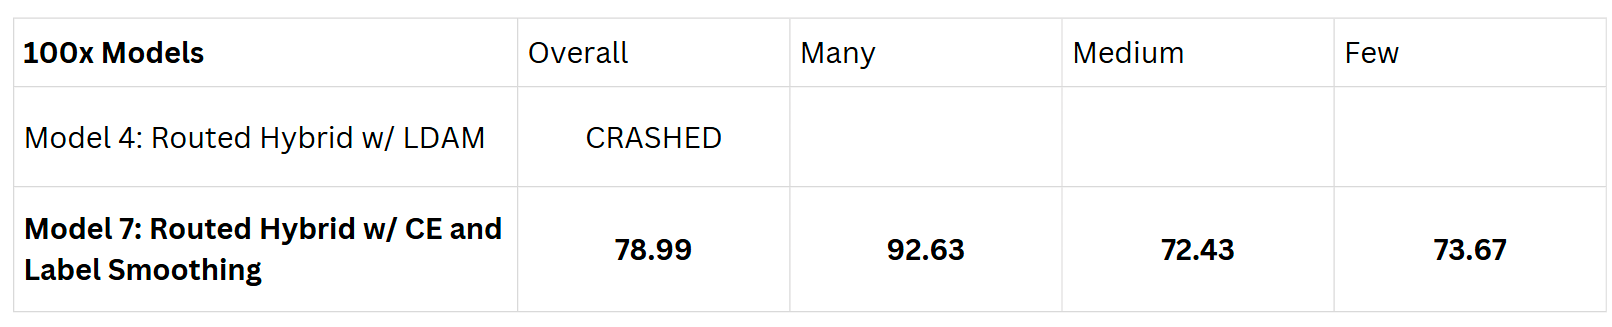

# Phase 3: Full Power Hybrid Model with Loss Accumulation. Models[5,6]

In this I am going to implement a ResLT Loss with a grouped conv at each early exits.

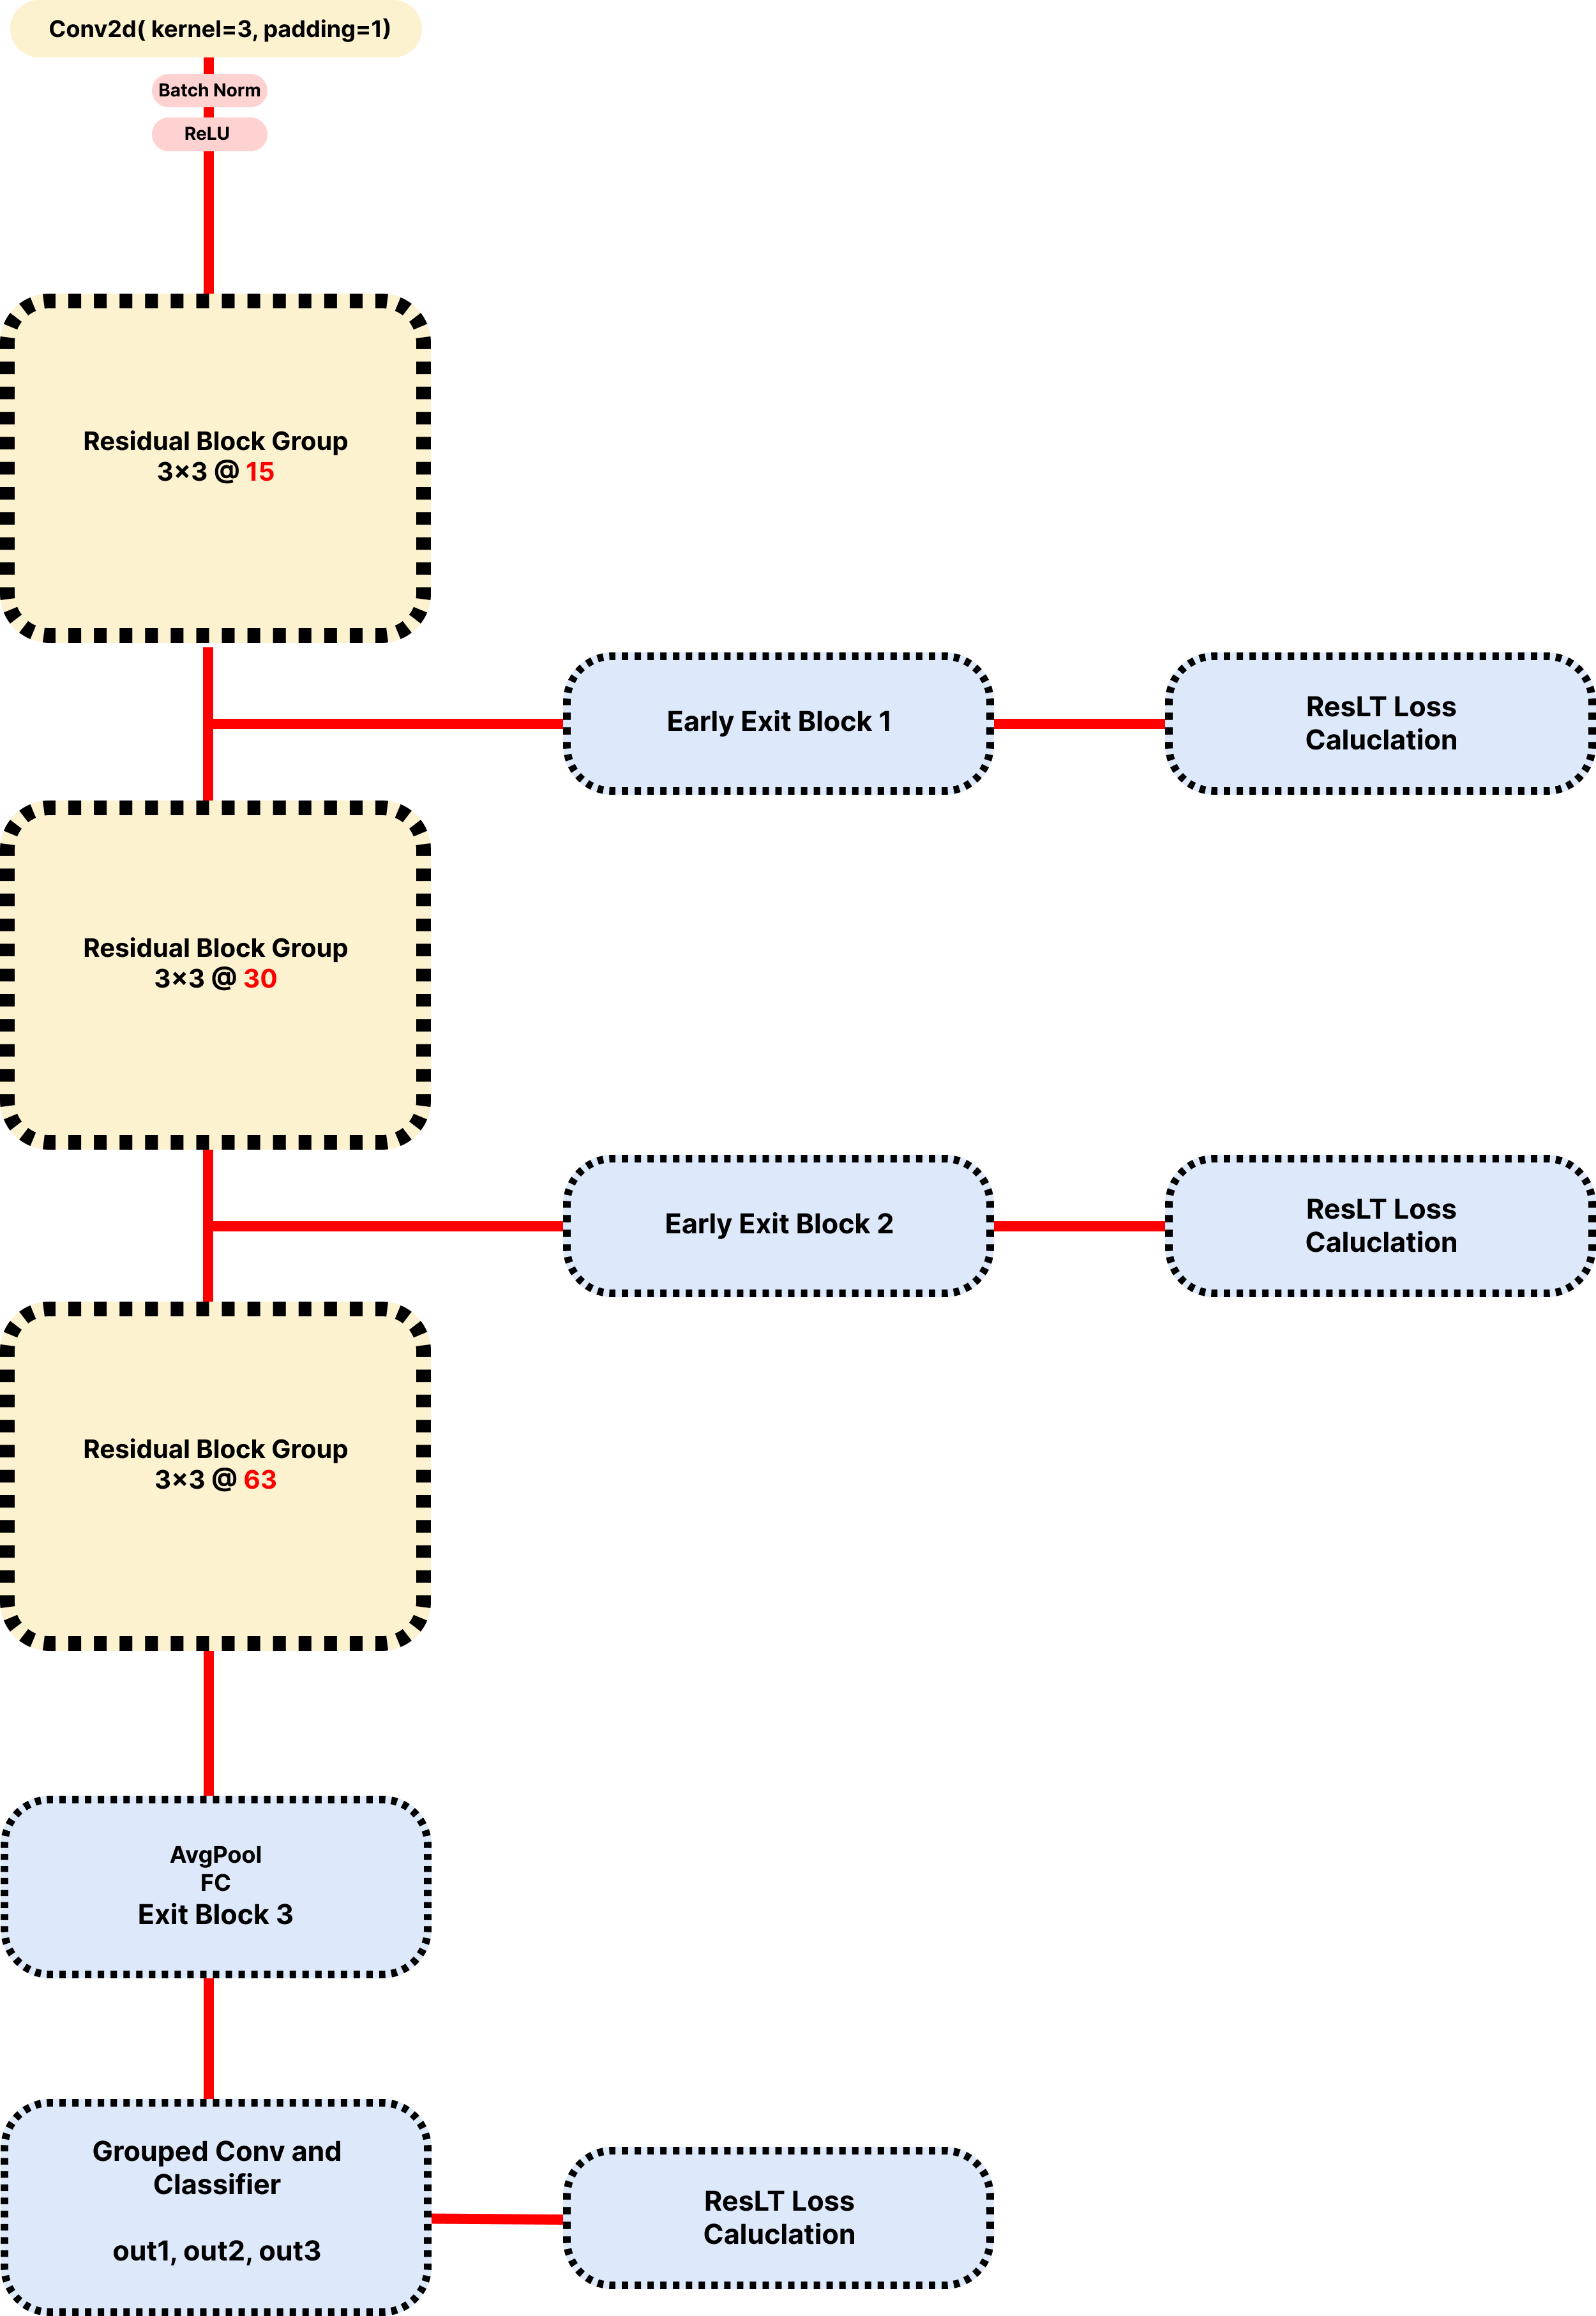

I have changed the resnet Residual block's out_channels from 16,32,64 to 15,30,63 (nearest multiple of 3)

Hybrid Model 5: Full Power Model with LDAM Loss function and Loss accumulation (Accumulative Model)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time
# Import the files module for Google Colab
from google.colab import files

# =============================================================================
# CELL 1: DATASET LOADER & LOSS FUNCTIONS (Unchanged)
# =============================================================================
def get_cifar10_lt_loaders(batch_size=128, imbalance_ratio=100, root='./data'):
    """Creates long-tailed versions of the CIFAR-10 dataset with AutoAugment."""
    mu = 1 / imbalance_ratio
    num_classes = 10
    max_per_class = 5000

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_train_dataset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    targets = np.array(full_train_dataset.targets)
    class_counts = [int(max_per_class * mu ** (i / (num_classes - 1))) for i in range(num_classes)]

    selected_indices = []
    for cls, count in enumerate(class_counts):
        cls_indices = np.where(targets == cls)[0]
        selected = np.random.choice(cls_indices, count, replace=False)
        selected_indices.extend(selected)

    train_lt_dataset = Subset(full_train_dataset, selected_indices)
    train_loader = DataLoader(train_lt_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, class_counts

class LDAMLoss(nn.Module):
    def __init__(self, class_counts, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        margins = 1.0 / np.power(class_counts, 0.25)
        self.margins = torch.tensor(margins * (max_m / np.max(margins)), dtype=torch.float)
        self.weight = weight
        self.s = s

    def forward(self, logits, labels):
        if logits.device != self.margins.device: self.margins = self.margins.to(logits.device)
        if self.weight is not None and self.weight.device != logits.device: self.weight = self.weight.to(logits.device)
        index = torch.zeros_like(logits, dtype=torch.bool); index.scatter_(1, labels.data.view(-1, 1), 1)
        margin_adjusted_logits = logits - self.margins[labels].unsqueeze(1) * index.float()
        return F.cross_entropy(self.s * margin_adjusted_logits, labels, weight=self.weight, reduction='none')

def get_drw_weights(epoch, class_counts, drw_start_epoch, beta=0.9999):
    if epoch < drw_start_epoch: return None
    effective_num = 1.0 - np.power(beta, class_counts)
    weights = (1.0 - beta) / effective_num
    weights = weights / np.sum(weights) * len(class_counts)
    return torch.tensor(weights, dtype=torch.float)

# =============================================================================
# CELL 2: "FULL POWER" HYBRID MODEL ARCHITECTURE
# =============================================================================
class Hybrid_BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Hybrid_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        return self.relu(out)

class ResLT_Head(nn.Module):
    """A reusable ResLT Head module."""
    def __init__(self, in_features, num_classes):
        super(ResLT_Head, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        num_final_features = (in_features // 3) * 3
        if in_features != num_final_features:
            print(f"Warning: Adjusting in_features from {in_features} to {num_final_features} for ResLT Head.")

        self.feature_adjust = nn.Identity()
        if in_features != num_final_features:
             self.feature_adjust = nn.Conv2d(in_features, num_final_features, kernel_size=1, bias=False)

        self.group_conv = nn.Conv2d(num_final_features, num_final_features * 3, kernel_size=1, groups=3, bias=False)
        self.classifier = nn.Linear(num_final_features, num_classes)

    def forward(self, x):
        out = self.avgpool(x)
        out = self.feature_adjust(out)
        features = out.view(out.size(0), -1)
        features_2d = features.view(features.size(0), -1, 1, 1)
        grouped_features = self.group_conv(features_2d).view(features.size(0), 3, -1)
        out1 = self.classifier(grouped_features[:, 0, :])
        out2 = self.classifier(grouped_features[:, 1, :])
        out3 = self.classifier(grouped_features[:, 2, :])
        return out1, out2, out3

class Hybrid_Full_ResLT_Model(nn.Module):
    def __init__(self, block=Hybrid_BasicBlock, num_blocks=[5, 5, 5], num_classes=10):
        super(Hybrid_Full_ResLT_Model, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        self.exit1 = ResLT_Head(16, num_classes)
        self.exit2 = ResLT_Head(32, num_classes)
        self.final_exit = ResLT_Head(64, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        all_outputs = []
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        all_outputs.append(self.exit1(out))
        out = self.layer2(out)
        all_outputs.append(self.exit2(out))
        out = self.layer3(out)
        all_outputs.append(self.final_exit(out))
        return all_outputs

# =============================================================================
# CELL 3: TRAINING AND EVALUATION SCRIPT
# =============================================================================

def calculate_full_reslt_loss(outputs, labels, criterion, alpha, class_splits, device):
    out1, out2, out3 = outputs
    loss_fusion = criterion(out1 + out2 + out3, labels)
    many, medium, few = class_splits['many'], class_splits['medium'], class_splits['few']
    loss_branch1 = criterion(out1, labels)
    medium_tail_mask = torch.isin(labels, torch.tensor(medium + few).to(device))
    tail_mask = torch.isin(labels, torch.tensor(few).to(device))
    loss_branch2 = torch.zeros_like(loss_branch1)
    if medium_tail_mask.sum() > 0:
        loss_branch2[medium_tail_mask] = criterion(out2[medium_tail_mask], labels[medium_tail_mask])
    loss_branch3 = torch.zeros_like(loss_branch1)
    if tail_mask.sum() > 0:
        loss_branch3[tail_mask] = criterion(out3[tail_mask], labels[tail_mask])
    loss_branch = loss_branch1 + loss_branch2 + loss_branch3
    return (1 - alpha) * loss_fusion + alpha * loss_branch

def train_full_hybrid(model, loader, optimizer, criterion_builder, alpha, class_splits, exit_thresh, device, epoch, drw_start, class_counts):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        drw_weights = get_drw_weights(epoch, class_counts, drw_start)
        criterion = criterion_builder(class_counts, weight=drw_weights).to(device)

        all_outputs = model(images)
        batch_size = labels.size(0)
        per_sample_loss = torch.zeros(batch_size, device=device)
        has_exited = torch.zeros(batch_size, dtype=torch.bool, device=device)

        for i in range(len(all_outputs)):
            outputs_at_exit = all_outputs[i]
            loss_component = calculate_full_reslt_loss(outputs_at_exit, labels, criterion, alpha, class_splits, device)
            per_sample_loss += loss_component * (~has_exited).float()

            fused_output = outputs_at_exit[0] + outputs_at_exit[1] + outputs_at_exit[2]
            probs = F.softmax(fused_output, dim=1)
            confs, preds = torch.max(probs, dim=1)
            exited_now = (preds == labels) & (confs > exit_thresh)
            has_exited |= exited_now
            if has_exited.all(): break

        final_loss = per_sample_loss.mean()
        final_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += final_loss.item()
    return total_loss / len(loader)

def evaluate_full_hybrid(model, loader, class_splits, inference_thresh, device):
    model.eval()
    correct = {k: 0 for k in class_splits.keys()}
    total = {k: 0 for k in class_splits.keys()}
    correct['all'], total['all'] = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            all_outputs = model(images)

            fused_outputs = [out[0] + out[1] + out[2] for out in all_outputs]
            preds_at_exits = [torch.max(fused, 1)[1] for fused in fused_outputs]
            confidences = [torch.max(F.softmax(fused, dim=1), 1)[0] for fused in fused_outputs]

            final_prediction = torch.zeros_like(labels)
            exited_mask = torch.zeros_like(labels, dtype=torch.bool)
            for i in range(len(preds_at_exits)):
                exit_now_mask = (confidences[i] > inference_thresh) & (~exited_mask)
                final_prediction[exit_now_mask] = preds_at_exits[i][exit_now_mask]
                exited_mask |= exit_now_mask

            final_prediction[~exited_mask] = preds_at_exits[-1][~exited_mask]

            for i in range(labels.size(0)):
                label, pred = labels[i].item(), final_prediction[i].item()
                is_correct = (pred == label)
                total['all'] += 1
                if is_correct: correct['all'] += 1
                if label in class_splits['many']:
                    total['many'] += 1
                    if is_correct: correct['many'] += 1
                elif label in class_splits['medium']:
                    total['medium'] += 1
                    if is_correct: correct['medium'] += 1
                elif label in class_splits['few']:
                    total['few'] += 1
                    if is_correct: correct['few'] += 1

    accuracies = {k: 100 * correct[k] / total[k] if total[k] > 0 else 0 for k in total}
    return accuracies

def main_full_hybrid():
    # --- Hyperparameters ---
    NUM_EPOCHS, BATCH_SIZE, BASE_LR, MOMENTUM = 200, 128, 0.1, 0.9
    ALPHA, IMBALANCE_RATIO, WARMUP_EPOCHS = 0.95, 100, 5
    TRAIN_THRESH, INFER_THRESH, DRW_START = 0.5, 0.5, 160

    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader, class_counts = get_cifar10_lt_loaders(BATCH_SIZE, IMBALANCE_RATIO)
    class_splits = {'many': [0, 1, 2], 'medium': [3, 4, 5], 'few': [6, 7, 8, 9]}
    model = Hybrid_Full_ResLT_Model(num_classes=10).to(device)
    criterion_builder = LDAMLoss
    optimizer = optim.SGD(model.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=2e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)
    history = {
        'train_acc': [], 'test_acc': [],
        'test_acc_many': [], 'test_acc_medium': [], 'test_acc_few': []
    }

    print("--- Starting Full Power Hybrid Training ---")
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        if epoch < WARMUP_EPOCHS:
            lr = BASE_LR * (epoch + 1) / WARMUP_EPOCHS
            for pg in optimizer.param_groups: pg['lr'] = lr
        else:
            lr = scheduler.get_last_lr()[0]

        avg_loss = train_full_hybrid(model, train_loader, optimizer, criterion_builder, ALPHA, class_splits, TRAIN_THRESH, device, epoch, DRW_START, class_counts)
        if epoch >= WARMUP_EPOCHS: scheduler.step()

        train_accuracies = evaluate_full_hybrid(model, train_loader, class_splits, INFER_THRESH, device)
        test_accuracies = evaluate_full_hybrid(model, test_loader, class_splits, INFER_THRESH, device)

        for key in history.keys():
            history[key].append(test_accuracies.get(key, train_accuracies.get(key)))

        print(f"Epoch {epoch+1:03d} | Time: {time.time()-start_time:.1f}s | LR: {lr:.5f} | "
              f"Loss: {avg_loss:.4f} | Train Acc: {train_accuracies['all']:.2f}% | Test Acc: {test_accuracies['all']:.2f}% | "
              f"(Many: {test_accuracies['many']:.2f}%, Medium: {test_accuracies['medium']:.2f}%, Few: {test_accuracies['few']:.2f}%)")

    print("\nTraining complete.")

    # --- Automatic Download for Colab ---
    saved_files = []
    model_save_path = f"full_hybrid_imbalance_{IMBALANCE_RATIO}.pth"
    torch.save(model.state_dict(), model_save_path)
    saved_files.append(model_save_path)

    for key, values in history.items():
        file_path = f"full_hybrid_{key}_imbalance_{IMBALANCE_RATIO}.npy"
        np.save(file_path, np.array(values))
        saved_files.append(file_path)

    print("\nAll artifacts saved to Colab environment.")
    print("Triggering downloads to local machine...")
    for file_path in saved_files:
        files.download(file_path)
    print("Downloads complete.")

# Direct execution
main_full_hybrid()


100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


--- Starting Full Power Hybrid Training ---
Epoch 001 | Time: 21.2s | LR: 0.02000 | Loss: 30.9550 | Train Acc: 21.87% | Test Acc: 18.51% | (Many: 30.87%, Medium: 0.07%, Few: 23.07%)
Epoch 002 | Time: 21.1s | LR: 0.04000 | Loss: 28.5913 | Train Acc: 27.59% | Test Acc: 20.29% | (Many: 31.33%, Medium: 25.90%, Few: 7.80%)
Epoch 003 | Time: 20.6s | LR: 0.06000 | Loss: 29.4429 | Train Acc: 20.86% | Test Acc: 20.01% | (Many: 29.87%, Medium: 0.00%, Few: 27.62%)
Epoch 004 | Time: 20.0s | LR: 0.08000 | Loss: 31.3495 | Train Acc: 28.59% | Test Acc: 24.82% | (Many: 37.70%, Medium: 27.30%, Few: 13.30%)
Epoch 005 | Time: 20.4s | LR: 0.10000 | Loss: 31.5176 | Train Acc: 36.79% | Test Acc: 17.39% | (Many: 32.00%, Medium: 0.00%, Few: 19.48%)
Epoch 006 | Time: 19.3s | LR: 0.10000 | Loss: 33.9451 | Train Acc: 16.65% | Test Acc: 20.31% | (Many: 27.20%, Medium: 0.00%, Few: 30.38%)
Epoch 007 | Time: 20.4s | LR: 0.10000 | Loss: 31.7526 | Train Acc: 21.44% | Test Acc: 24.75% | (Many: 33.57%, Medium: 0.00%, Fe

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloads complete.


Hybrid Model 6: Full Power Model with Cross Entropy Loss Fn and Loss Accumulation (Accumulative Loss Model)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time
# Import the files module for Google Colab
from google.colab import files

# =============================================================================
# CELL 1: DATASET LOADER
# =============================================================================
def get_cifar10_lt_loaders(batch_size=128, imbalance_ratio=100, root='./data'):
    """Creates long-tailed versions of the CIFAR-10 dataset with AutoAugment."""
    mu = 1 / imbalance_ratio
    num_classes = 10
    max_per_class = 5000

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_train_dataset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    targets = np.array(full_train_dataset.targets)
    class_counts = [int(max_per_class * mu ** (i / (num_classes - 1))) for i in range(num_classes)]

    selected_indices = []
    for cls, count in enumerate(class_counts):
        cls_indices = np.where(targets == cls)[0]
        selected = np.random.choice(cls_indices, count, replace=False)
        selected_indices.extend(selected)

    train_lt_dataset = Subset(full_train_dataset, selected_indices)
    train_loader = DataLoader(train_lt_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, class_counts

# =============================================================================
# CELL 2: "FULL POWER" HYBRID MODEL ARCHITECTURE
# =============================================================================
class Hybrid_BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Hybrid_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        return self.relu(out)

class ResLT_Head(nn.Module):
    """A reusable ResLT Head module."""
    def __init__(self, in_features, num_classes):
        super(ResLT_Head, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        num_final_features = (in_features // 3) * 3
        if in_features != num_final_features:
            print(f"Warning: Adjusting in_features from {in_features} to {num_final_features} for ResLT Head.")

        self.feature_adjust = nn.Identity()
        if in_features != num_final_features:
             self.feature_adjust = nn.Conv2d(in_features, num_final_features, kernel_size=1, bias=False)

        self.group_conv = nn.Conv2d(num_final_features, num_final_features * 3, kernel_size=1, groups=3, bias=False)
        self.classifier = nn.Linear(num_final_features, num_classes)

    def forward(self, x):
        out = self.avgpool(x)
        out = self.feature_adjust(out)
        features = out.view(out.size(0), -1)
        features_2d = features.view(features.size(0), -1, 1, 1)
        grouped_features = self.group_conv(features_2d).view(features.size(0), 3, -1)
        out1 = self.classifier(grouped_features[:, 0, :])
        out2 = self.classifier(grouped_features[:, 1, :])
        out3 = self.classifier(grouped_features[:, 2, :])
        return out1, out2, out3

class Hybrid_Full_ResLT_Model(nn.Module):
    def __init__(self, block=Hybrid_BasicBlock, num_blocks=[5, 5, 5], num_classes=10):
        super(Hybrid_Full_ResLT_Model, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        self.exit1 = ResLT_Head(16, num_classes)
        self.exit2 = ResLT_Head(32, num_classes)
        self.final_exit = ResLT_Head(64, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        all_outputs = []
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        all_outputs.append(self.exit1(out))
        out = self.layer2(out)
        all_outputs.append(self.exit2(out))
        out = self.layer3(out)
        all_outputs.append(self.final_exit(out))
        return all_outputs

# =============================================================================
# CELL 3: TRAINING AND EVALUATION SCRIPT
# =============================================================================

def calculate_full_reslt_loss(outputs, labels, criterion, alpha, class_splits, device):
    out1, out2, out3 = outputs
    # Set reduction to 'none' to get per-sample loss
    criterion.reduction = 'none'

    loss_fusion = criterion(out1 + out2 + out3, labels)
    many, medium, few = class_splits['many'], class_splits['medium'], class_splits['few']
    loss_branch1 = criterion(out1, labels)
    medium_tail_mask = torch.isin(labels, torch.tensor(medium + few).to(device))
    tail_mask = torch.isin(labels, torch.tensor(few).to(device))

    loss_branch2 = torch.zeros_like(loss_branch1)
    if medium_tail_mask.sum() > 0:
        loss_branch2[medium_tail_mask] = criterion(out2[medium_tail_mask], labels[medium_tail_mask])

    loss_branch3 = torch.zeros_like(loss_branch1)
    if tail_mask.sum() > 0:
        loss_branch3[tail_mask] = criterion(out3[tail_mask], labels[tail_mask])

    loss_branch = loss_branch1 + loss_branch2 + loss_branch3
    return (1 - alpha) * loss_fusion + alpha * loss_branch

def train_full_hybrid(model, loader, optimizer, criterion, alpha, class_splits, exit_thresh, device):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        all_outputs = model(images)
        batch_size = labels.size(0)
        per_sample_loss = torch.zeros(batch_size, device=device)
        has_exited = torch.zeros(batch_size, dtype=torch.bool, device=device)

        for i in range(len(all_outputs)):
            outputs_at_exit = all_outputs[i]
            loss_component = calculate_full_reslt_loss(outputs_at_exit, labels, criterion, alpha, class_splits, device)
            per_sample_loss += loss_component * (~has_exited).float()

            fused_output = outputs_at_exit[0] + outputs_at_exit[1] + outputs_at_exit[2]
            probs = F.softmax(fused_output, dim=1)
            confs, preds = torch.max(probs, dim=1)
            exited_now = (preds == labels) & (confs > exit_thresh)
            has_exited |= exited_now
            if has_exited.all(): break

        final_loss = per_sample_loss.mean()
        final_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += final_loss.item()
    return total_loss / len(loader)

def evaluate_full_hybrid(model, loader, class_splits, inference_thresh, device):
    model.eval()
    correct = {k: 0 for k in class_splits.keys()}
    total = {k: 0 for k in class_splits.keys()}
    correct['all'], total['all'] = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            all_outputs = model(images)

            fused_outputs = [out[0] + out[1] + out[2] for out in all_outputs]
            preds_at_exits = [torch.max(fused, 1)[1] for fused in fused_outputs]
            confidences = [torch.max(F.softmax(fused, dim=1), 1)[0] for fused in fused_outputs]

            final_prediction = torch.zeros_like(labels)
            exited_mask = torch.zeros_like(labels, dtype=torch.bool)
            for i in range(len(preds_at_exits)):
                exit_now_mask = (confidences[i] > inference_thresh) & (~exited_mask)
                final_prediction[exit_now_mask] = preds_at_exits[i][exit_now_mask]
                exited_mask |= exit_now_mask

            final_prediction[~exited_mask] = preds_at_exits[-1][~exited_mask]

            for i in range(labels.size(0)):
                label, pred = labels[i].item(), final_prediction[i].item()
                is_correct = (pred == label)
                total['all'] += 1
                if is_correct: correct['all'] += 1
                if label in class_splits['many']:
                    total['many'] += 1
                    if is_correct: correct['many'] += 1
                elif label in class_splits['medium']:
                    total['medium'] += 1
                    if is_correct: correct['medium'] += 1
                elif label in class_splits['few']:
                    total['few'] += 1
                    if is_correct: correct['few'] += 1

    accuracies = {k: 100 * correct[k] / total[k] if total[k] > 0 else 0 for k in total}
    return accuracies

def main_full_hybrid_ce():
    # --- Hyperparameters ---
    NUM_EPOCHS, BATCH_SIZE, BASE_LR, MOMENTUM = 200, 128, 0.1, 0.9
    ALPHA, IMBALANCE_RATIO, WARMUP_EPOCHS = 0.95, 100, 5
    TRAIN_THRESH, INFER_THRESH = 0.9, 0.5 # Using values appropriate for CE

    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader, class_counts = get_cifar10_lt_loaders(BATCH_SIZE, IMBALANCE_RATIO)
    class_splits = {'many': [0, 1, 2], 'medium': [3, 4, 5], 'few': [6, 7, 8, 9]}
    model = Hybrid_Full_ResLT_Model(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # Using CE Loss
    optimizer = optim.SGD(model.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=2e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)
    history = {
        'train_acc': [], 'test_acc': [],
        'test_acc_many': [], 'test_acc_medium': [], 'test_acc_few': []
    }

    print("--- Starting Full Power Hybrid Training (Cross-Entropy Version) ---")
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        if epoch < WARMUP_EPOCHS:
            lr = BASE_LR * (epoch + 1) / WARMUP_EPOCHS
            for pg in optimizer.param_groups: pg['lr'] = lr
        else:
            lr = scheduler.get_last_lr()[0]

        avg_loss = train_full_hybrid(model, train_loader, optimizer, criterion, ALPHA, class_splits, TRAIN_THRESH, device)
        if epoch >= WARMUP_EPOCHS: scheduler.step()

        train_accuracies = evaluate_full_hybrid(model, train_loader, class_splits, INFER_THRESH, device)
        test_accuracies = evaluate_full_hybrid(model, test_loader, class_splits, INFER_THRESH, device)

        for key in history.keys():
            history[key].append(test_accuracies.get(key, train_accuracies.get(key)))

        print(f"Epoch {epoch+1:03d} | Time: {time.time()-start_time:.1f}s | LR: {lr:.5f} | "
              f"Loss: {avg_loss:.4f} | Train Acc: {train_accuracies['all']:.2f}% | Test Acc: {test_accuracies['all']:.2f}% | "
              f"(Many: {test_accuracies['many']:.2f}%, Medium: {test_accuracies['medium']:.2f}%, Few: {test_accuracies['few']:.2f}%)")

    print("\nTraining complete.")

    # --- Automatic Download for Colab ---
    saved_files = []
    model_save_path = f"full_hybrid_ce_imbalance_{IMBALANCE_RATIO}.pth"
    torch.save(model.state_dict(), model_save_path)
    saved_files.append(model_save_path)

    for key, values in history.items():
        file_path = f"full_hybrid_ce_{key}_imbalance_{IMBALANCE_RATIO}.npy"
        np.save(file_path, np.array(values))
        saved_files.append(file_path)

    print("\nAll artifacts saved to Colab environment.")
    print("Triggering downloads to local machine...")
    for file_path in saved_files:
        files.download(file_path)
    print("Downloads complete.")

# Direct execution
main_full_hybrid_ce()


100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


--- Starting Full Power Hybrid Training (Cross-Entropy Version) ---
Epoch 001 | Time: 23.0s | LR: 0.02000 | Loss: 6.4195 | Train Acc: 30.44% | Test Acc: 19.58% | (Many: 31.10%, Medium: 2.03%, Few: 24.10%)
Epoch 002 | Time: 20.6s | LR: 0.04000 | Loss: 5.9064 | Train Acc: 31.77% | Test Acc: 18.85% | (Many: 31.77%, Medium: 29.03%, Few: 1.52%)
Epoch 003 | Time: 19.7s | LR: 0.06000 | Loss: 5.7286 | Train Acc: 40.55% | Test Acc: 22.69% | (Many: 51.53%, Medium: 6.40%, Few: 13.28%)
Epoch 004 | Time: 20.4s | LR: 0.08000 | Loss: 5.5008 | Train Acc: 53.97% | Test Acc: 25.43% | (Many: 61.10%, Medium: 0.00%, Few: 17.75%)
Epoch 005 | Time: 20.2s | LR: 0.10000 | Loss: 5.3794 | Train Acc: 47.09% | Test Acc: 25.41% | (Many: 51.40%, Medium: 1.30%, Few: 24.00%)
Epoch 006 | Time: 20.5s | LR: 0.10000 | Loss: 5.2568 | Train Acc: 58.54% | Test Acc: 24.60% | (Many: 58.40%, Medium: 23.17%, Few: 0.33%)
Epoch 007 | Time: 20.2s | LR: 0.10000 | Loss: 5.1610 | Train Acc: 59.04% | Test Acc: 27.36% | (Many: 64.60%, M

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloads complete.


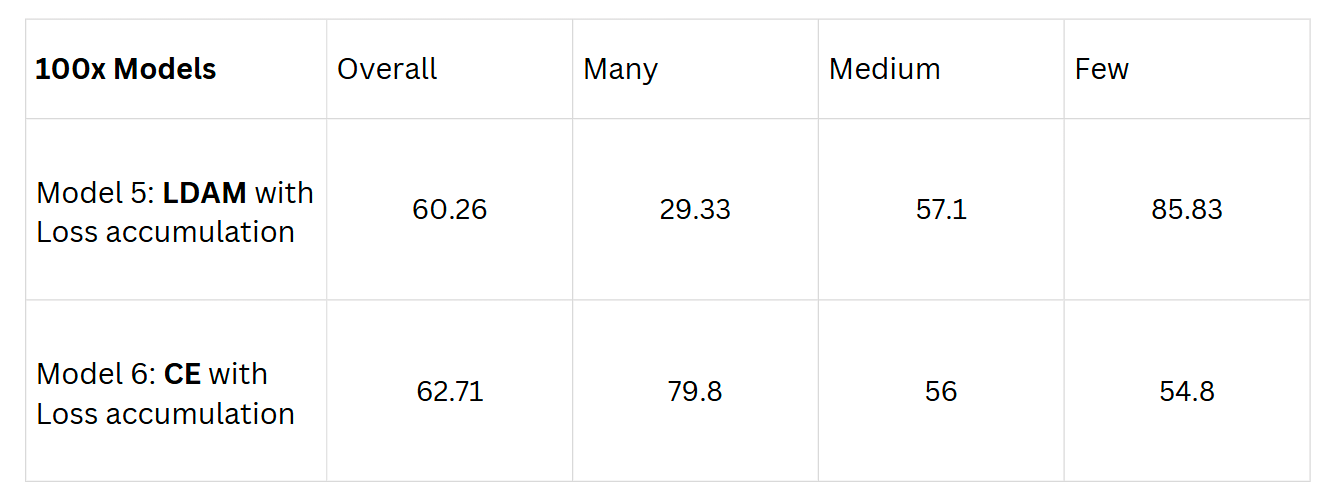

These Models have yielded accuracy lower than the Simulated Loss Models possibly due to high complexity.

# Phase 4: Full Power Hybrid Models without Loss Accumulations [Models 14,15,16]

I retried the same exact implementation of Models 6 (Cross Entropy), but without Accumulation of Loss

Hybrid Model 14: Routed -Full Power Model with Cross Entropy (No accumulation of loss)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time
# Import the files module for Google Colab
from google.colab import files

# =============================================================================
# CELL 1: DATASET LOADER
# =============================================================================
def get_cifar10_lt_loaders(batch_size=128, imbalance_ratio=100, root='./data'):
    """Creates long-tailed versions of the CIFAR-10 dataset with AutoAugment."""
    mu = 1 / imbalance_ratio
    num_classes = 10
    max_per_class = 5000

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_train_dataset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    targets = np.array(full_train_dataset.targets)
    class_counts = [int(max_per_class * mu ** (i / (num_classes - 1))) for i in range(num_classes)]

    selected_indices = []
    for cls, count in enumerate(class_counts):
        cls_indices = np.where(targets == cls)[0]
        selected = np.random.choice(cls_indices, count, replace=False)
        selected_indices.extend(selected)

    train_lt_dataset = Subset(full_train_dataset, selected_indices)
    train_loader = DataLoader(train_lt_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, class_counts

# =============================================================================
# CELL 2: "FULL POWER" HYBRID MODEL ARCHITECTURE
# =============================================================================
class Hybrid_BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Hybrid_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        return self.relu(out)

class ResLT_Head(nn.Module):
    """A reusable ResLT Head module."""
    def __init__(self, in_features, num_classes):
        super(ResLT_Head, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        num_final_features = (in_features // 3) * 3
        if in_features != num_final_features:
            print(f"Warning: Adjusting in_features from {in_features} to {num_final_features} for ResLT Head.")

        self.feature_adjust = nn.Identity()
        if in_features != num_final_features:
             self.feature_adjust = nn.Conv2d(in_features, num_final_features, kernel_size=1, bias=False)

        self.group_conv = nn.Conv2d(num_final_features, num_final_features * 3, kernel_size=1, groups=3, bias=False)
        self.classifier = nn.Linear(num_final_features, num_classes)

    def forward(self, x):
        out = self.avgpool(x)
        out = self.feature_adjust(out)
        features = out.view(out.size(0), -1)
        features_2d = features.view(features.size(0), -1, 1, 1)
        grouped_features = self.group_conv(features_2d).view(features.size(0), 3, -1)
        out1 = self.classifier(grouped_features[:, 0, :])
        out2 = self.classifier(grouped_features[:, 1, :])
        out3 = self.classifier(grouped_features[:, 2, :])
        return out1, out2, out3

class Hybrid_Full_ResLT_Model(nn.Module):
    def __init__(self, block=Hybrid_BasicBlock, num_blocks=[5, 5, 5], num_classes=10):
        super(Hybrid_Full_ResLT_Model, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        self.exit1 = ResLT_Head(16, num_classes)
        self.exit2 = ResLT_Head(32, num_classes)
        self.final_exit = ResLT_Head(64, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        all_outputs = []
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        all_outputs.append(self.exit1(out))
        out = self.layer2(out)
        all_outputs.append(self.exit2(out))
        out = self.layer3(out)
        all_outputs.append(self.final_exit(out))
        return all_outputs

# =============================================================================
# CELL 3: TRAINING AND EVALUATION SCRIPT (WITH ROUTED LOSS)
# =============================================================================

def calculate_full_reslt_loss(outputs, labels, criterion, alpha, class_splits, device):
    out1, out2, out3 = outputs

    # Temporarily set reduction to 'none' to get per-sample loss
    original_reduction = criterion.reduction
    criterion.reduction = 'none'

    loss_fusion = criterion(out1 + out2 + out3, labels)
    many, medium, few = class_splits['many'], class_splits['medium'], class_splits['few']
    loss_branch1 = criterion(out1, labels)
    medium_tail_mask = torch.isin(labels, torch.tensor(medium + few).to(device))
    tail_mask = torch.isin(labels, torch.tensor(few).to(device))

    loss_branch2 = torch.zeros_like(loss_branch1)
    if medium_tail_mask.sum() > 0:
        loss_branch2[medium_tail_mask] = criterion(out2[medium_tail_mask], labels[medium_tail_mask])

    loss_branch3 = torch.zeros_like(loss_branch1)
    if tail_mask.sum() > 0:
        loss_branch3[tail_mask] = criterion(out3[tail_mask], labels[tail_mask])

    loss_branch = loss_branch1 + loss_branch2 + loss_branch3

    # Restore original reduction
    criterion.reduction = original_reduction

    return (1 - alpha) * loss_fusion + alpha * loss_branch

def train_routed_full_hybrid(model, loader, optimizer, criterion, alpha, class_splits, exit_thresh, device):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        all_outputs = model(images)
        batch_size = labels.size(0)
        per_sample_loss = torch.zeros(batch_size, device=device)
        has_exited = torch.zeros(batch_size, dtype=torch.bool, device=device)

        # --- ROUTED LOSS LOGIC ---
        for i in range(len(all_outputs)):
            outputs_at_exit = all_outputs[i]
            not_exited_mask = ~has_exited

            if not_exited_mask.sum() == 0: break

            fused_output = outputs_at_exit[0][not_exited_mask] + outputs_at_exit[1][not_exited_mask] + outputs_at_exit[2][not_exited_mask]
            probs = F.softmax(fused_output, dim=1)
            confs, preds = torch.max(probs, dim=1)

            # Determine who exits now, only check last exit for remaining samples
            if i == len(all_outputs) - 1:
                exited_now_mask_local = torch.ones_like(preds, dtype=torch.bool)
            else:
                exited_now_mask_local = (preds == labels[not_exited_mask]) & (confs > exit_thresh)

            global_indices_exiting_now = not_exited_mask.nonzero(as_tuple=True)[0][exited_now_mask_local]

            if len(global_indices_exiting_now) > 0:
                current_outputs = (outputs_at_exit[0][global_indices_exiting_now],
                                   outputs_at_exit[1][global_indices_exiting_now],
                                   outputs_at_exit[2][global_indices_exiting_now])

                loss_component = calculate_full_reslt_loss(current_outputs, labels[global_indices_exiting_now], criterion, alpha, class_splits, device)
                per_sample_loss[global_indices_exiting_now] = loss_component
                has_exited[global_indices_exiting_now] = True

        final_loss = per_sample_loss.mean()
        final_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += final_loss.item()
    return total_loss / len(loader)


def evaluate_full_hybrid(model, loader, class_splits, inference_thresh, device):
    model.eval()
    correct = {k: 0 for k in class_splits.keys()}
    total = {k: 0 for k in class_splits.keys()}
    correct['all'], total['all'] = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            all_outputs = model(images)
            fused_outputs = [out[0] + out[1] + out[2] for out in all_outputs]
            preds_at_exits = [torch.max(fused, 1)[1] for fused in fused_outputs]
            confidences = [torch.max(F.softmax(fused, dim=1), 1)[0] for fused in fused_outputs]
            final_prediction = torch.zeros_like(labels)
            exited_mask = torch.zeros_like(labels, dtype=torch.bool)
            for i in range(len(preds_at_exits)):
                exit_now_mask = (confidences[i] > inference_thresh) & (~exited_mask)
                final_prediction[exit_now_mask] = preds_at_exits[i][exit_now_mask]
                exited_mask |= exit_now_mask
            final_prediction[~exited_mask] = preds_at_exits[-1][~exited_mask]
            for i in range(labels.size(0)):
                label, pred = labels[i].item(), final_prediction[i].item()
                is_correct = (pred == label)
                total['all'] += 1
                if is_correct: correct['all'] += 1
                if label in class_splits['many']:
                    total['many'] += 1;
                    if is_correct: correct['many'] += 1
                elif label in class_splits['medium']:
                    total['medium'] += 1
                    if is_correct: correct['medium'] += 1
                elif label in class_splits['few']:
                    total['few'] += 1
                    if is_correct: correct['few'] += 1
    accuracies = {k: 100 * correct[k] / total[k] if total[k] > 0 else 0 for k in total}
    return accuracies

def main_routed_full_hybrid_ce():
    # --- Hyperparameters ---
    NUM_EPOCHS, BATCH_SIZE, BASE_LR, MOMENTUM = 200, 128, 0.1, 0.9
    ALPHA, IMBALANCE_RATIO, WARMUP_EPOCHS = 0.95, 100, 5
    TRAIN_THRESH, INFER_THRESH = 0.9, 0.5

    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader, class_counts = get_cifar10_lt_loaders(BATCH_SIZE, IMBALANCE_RATIO)
    class_splits = {'many': [0, 1, 2], 'medium': [3, 4, 5], 'few': [6, 7, 8, 9]}
    model = Hybrid_Full_ResLT_Model(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.SGD(model.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=2e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)
    history = {'train_acc': [], 'test_acc': [], 'test_acc_many': [], 'test_acc_medium': [], 'test_acc_few': []}

    print("--- Starting ROUTED Full Power Hybrid (CE Version) ---")
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        if epoch < WARMUP_EPOCHS:
            lr = BASE_LR * (epoch + 1) / WARMUP_EPOCHS
            for pg in optimizer.param_groups: pg['lr'] = lr
        else:
            lr = scheduler.get_last_lr()[0]

        avg_loss = train_routed_full_hybrid(model, train_loader, optimizer, criterion, ALPHA, class_splits, TRAIN_THRESH, device)
        if epoch >= WARMUP_EPOCHS: scheduler.step()

        train_accuracies = evaluate_full_hybrid(model, train_loader, class_splits, INFER_THRESH, device)
        test_accuracies = evaluate_full_hybrid(model, test_loader, class_splits, INFER_THRESH, device)

        # --- FIX: Correctly append the detailed test accuracies to the history ---
        history['train_acc'].append(train_accuracies['all'])
        history['test_acc'].append(test_accuracies['all'])
        history['test_acc_many'].append(test_accuracies['many'])
        history['test_acc_medium'].append(test_accuracies['medium'])
        history['test_acc_few'].append(test_accuracies['few'])

        print(f"Epoch {epoch+1:03d} | Time: {time.time()-start_time:.1f}s | LR: {lr:.5f} | "
              f"Loss: {avg_loss:.4f} | Train Acc: {train_accuracies['all']:.2f}% | Test Acc: {test_accuracies['all']:.2f}% | "
              f"(Many: {test_accuracies['many']:.2f}%, Medium: {test_accuracies['medium']:.2f}%, Few: {test_accuracies['few']:.2f}%)")

    print("\nTraining complete.")

    # --- Automatic Download for Colab ---
    saved_files = []
    model_save_path = f"routed_full_hybrid_ce_imbalance_{IMBALANCE_RATIO}.pth"
    torch.save(model.state_dict(), model_save_path)
    saved_files.append(model_save_path)

    for key, values in history.items():
        file_path = f"routed_full_hybrid_ce_{key}_imbalance_{IMBALANCE_RATIO}.npy"
        np.save(file_path, np.array(values))
        saved_files.append(file_path)

    print("\nAll artifacts saved to Colab environment.")
    print("Triggering downloads to local machine...")
    for file_path in saved_files:
        files.download(file_path)
    print("Downloads complete.")

# Direct execution
main_routed_full_hybrid_ce()


100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s]


--- Starting ROUTED Full Power Hybrid (CE Version) ---
Epoch 001 | Time: 20.6s | LR: 0.02000 | Loss: 2.0898 | Train Acc: 32.13% | Test Acc: 16.87% | (Many: 38.87%, Medium: 0.67%, Few: 12.53%)
Epoch 002 | Time: 18.3s | LR: 0.04000 | Loss: 1.9249 | Train Acc: 49.56% | Test Acc: 24.64% | (Many: 51.80%, Medium: 19.60%, Few: 8.05%)
Epoch 003 | Time: 19.9s | LR: 0.06000 | Loss: 1.8578 | Train Acc: 56.92% | Test Acc: 29.12% | (Many: 63.97%, Medium: 20.73%, Few: 9.28%)
Epoch 004 | Time: 18.7s | LR: 0.08000 | Loss: 1.7839 | Train Acc: 53.48% | Test Acc: 23.25% | (Many: 61.97%, Medium: 11.23%, Few: 3.23%)
Epoch 005 | Time: 19.3s | LR: 0.10000 | Loss: 1.7664 | Train Acc: 59.19% | Test Acc: 26.73% | (Many: 73.30%, Medium: 6.93%, Few: 6.65%)
Epoch 006 | Time: 18.4s | LR: 0.10000 | Loss: 1.6972 | Train Acc: 54.75% | Test Acc: 31.86% | (Many: 59.63%, Medium: 29.77%, Few: 12.60%)
Epoch 007 | Time: 19.4s | LR: 0.10000 | Loss: 1.6546 | Train Acc: 52.39% | Test Acc: 30.91% | (Many: 66.90%, Medium: 8.07%,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloads complete.


The above model which was run for 100x dataset, yielded me really high accuracy, and so I implemented the same for 50x and 10x dataset which are models 15 and 16 respectively. Since the code is same for all, I have not put it here.

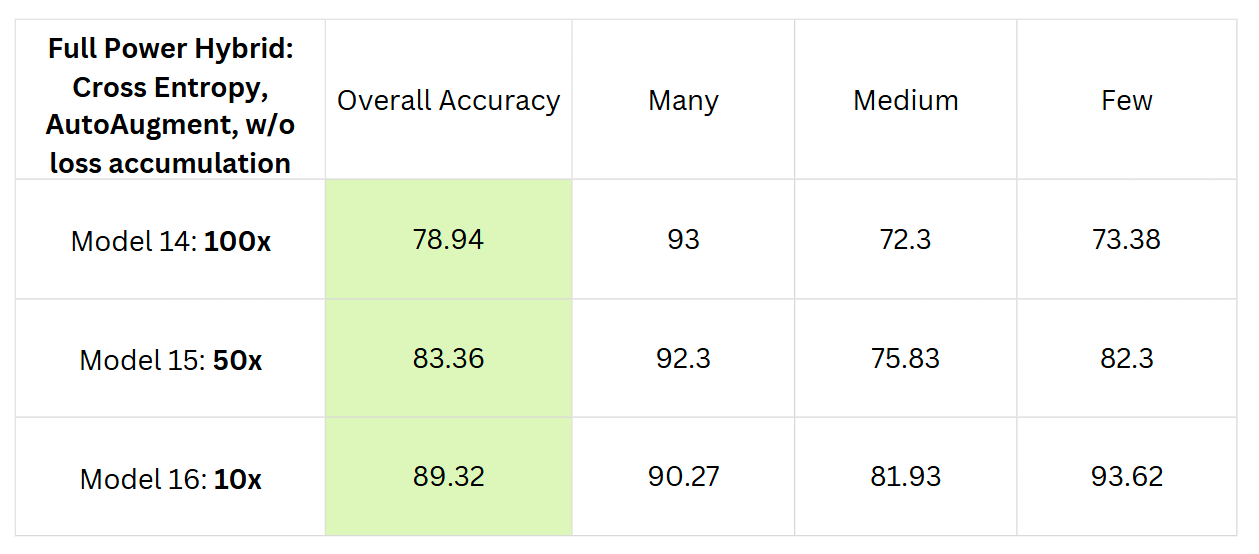

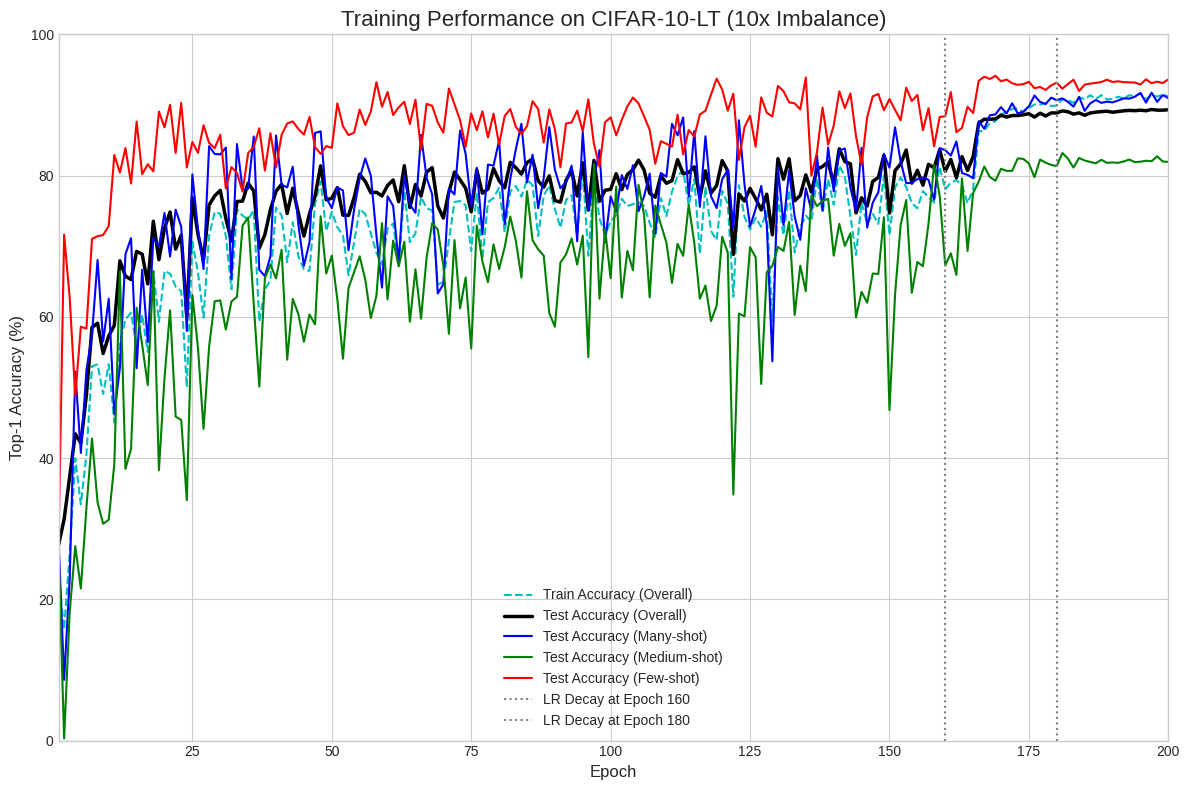

These are the highest ever accuracy of all the models that were run.

# Phase 5: Optimization of the Routed Models (Simulated loss) (Models 8, 12, 13)

I took my best architecture (Model 7: Routed Hybrid with CE w/o Loss Accumulation) and replaced AutoAugment with the more powerful Mixup augmentation on 100x.

I ran the Model 7 with Mixup augmentation on 100x,50x,10x which are the Models 8,12,13 respectively.

The only difference between Model 7 and Models[8,12,13] is a small section in dataset loading part(Removing AUtoAugment) and addition of Mixup Augmentation in the training Loop at train_routed_hybrid_mixup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time
# Import the files module for Google Colab
from google.colab import files

# =============================================================================
# CELL 1: DATASET LOADER & MIXUP FUNCTION
# =============================================================================
def get_cifar10_lt_loaders(batch_size=128, imbalance_ratio=100, root='./data'):
    """Creates long-tailed versions of the CIFAR-10 dataset."""
    mu = 1 / imbalance_ratio
    num_classes = 10
    max_per_class = 5000

    # AutoAugment is removed to be replaced by Mixup in the training loop
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_train_dataset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    targets = np.array(full_train_dataset.targets)
    class_counts = [int(max_per_class * mu ** (i / (num_classes - 1))) for i in range(num_classes)]

    selected_indices = []
    for cls, count in enumerate(class_counts):
        cls_indices = np.where(targets == cls)[0]
        selected = np.random.choice(cls_indices, count, replace=False)
        selected_indices.extend(selected)

    train_lt_dataset = Subset(full_train_dataset, selected_indices)
    train_loader = DataLoader(train_lt_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, class_counts

def mixup_data(x, y, alpha=1.0, device='cuda'):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# =============================================================================
# CELL 2: HYBRID MODEL ARCHITECTURE (Unchanged)
# =============================================================================
class Hybrid_BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Hybrid_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        return self.relu(out)

class Hybrid_Routed_Model(nn.Module):
    def __init__(self, block=Hybrid_BasicBlock, num_blocks=[5, 5, 5], num_classes=10):
        super(Hybrid_Routed_Model, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.exit1 = self._make_early_exit(16, num_classes)
        self.exit2 = self._make_early_exit(32, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        num_final_features = 48
        self.group_conv = nn.Conv2d(num_final_features, num_final_features * 3, kernel_size=1, groups=3, bias=False)
        self.classifier = nn.Linear(num_final_features, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def _make_early_exit(self, in_channels, num_classes):
        return nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(in_channels, num_classes))

    def forward(self, x):
        all_outputs = []
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        all_outputs.append(self.exit1(out))
        out = self.layer2(out)
        all_outputs.append(self.exit2(out))
        out = self.layer3(out)
        out = self.avgpool(out)
        features = out.view(out.size(0), -1)
        features_2d = features.view(features.size(0), -1, 1, 1)
        grouped_features = self.group_conv(features_2d).view(features.size(0), 3, -1)
        reslt_outs = (self.classifier(grouped_features[:, 0, :]),
                      self.classifier(grouped_features[:, 1, :]),
                      self.classifier(grouped_features[:, 2, :]))
        all_outputs.append(reslt_outs)
        return all_outputs

# =============================================================================
# CELL 3: TRAINING AND EVALUATION SCRIPT (WITH MIXUP)
# =============================================================================

def calculate_simulated_reslt_loss_mixup(output, y_a, y_b, lam, criterion, class_splits, device):
    loss_a = calculate_simulated_reslt_loss(output, y_a, criterion, class_splits, device)
    loss_b = calculate_simulated_reslt_loss(output, y_b, criterion, class_splits, device)
    return lam * loss_a + (1 - lam) * loss_b

def calculate_full_reslt_loss_mixup(outputs, y_a, y_b, lam, criterion, alpha, class_splits, device):
    loss_a = calculate_full_reslt_loss(outputs, y_a, criterion, alpha, class_splits, device)
    loss_b = calculate_full_reslt_loss(outputs, y_b, criterion, alpha, class_splits, device)
    return lam * loss_a + (1 - lam) * loss_b

# (Re-using the original calculate functions from the previous script)
def calculate_simulated_reslt_loss(output, labels, criterion, class_splits, device):
    loss_per_sample = criterion(output, labels)
    many, medium, few = class_splits['many'], class_splits['medium'], class_splits['few']
    medium_tail_mask = torch.isin(labels, torch.tensor(medium + few).to(device))
    tail_mask = torch.isin(labels, torch.tensor(few).to(device))
    if medium_tail_mask.sum() > 0:
        loss_per_sample[medium_tail_mask] += criterion(output[medium_tail_mask], labels[medium_tail_mask])
    if tail_mask.sum() > 0:
        loss_per_sample[tail_mask] += criterion(output[tail_mask], labels[tail_mask])
    return loss_per_sample

def calculate_full_reslt_loss(outputs, labels, criterion, alpha, class_splits, device):
    out1, out2, out3 = outputs
    loss_fusion = criterion(out1 + out2 + out3, labels)
    many, medium, few = class_splits['many'], class_splits['medium'], class_splits['few']
    loss_branch1 = criterion(out1, labels)
    medium_tail_mask = torch.isin(labels, torch.tensor(medium + few).to(device))
    tail_mask = torch.isin(labels, torch.tensor(few).to(device))
    loss_branch2 = torch.zeros_like(loss_branch1)
    if medium_tail_mask.sum() > 0:
        loss_branch2[medium_tail_mask] = criterion(out2[medium_tail_mask], labels[medium_tail_mask])
    loss_branch3 = torch.zeros_like(loss_branch1)
    if tail_mask.sum() > 0:
        loss_branch3[tail_mask] = criterion(out3[tail_mask], labels[tail_mask])
    loss_branch = loss_branch1 + loss_branch2 + loss_branch3
    return (1 - alpha) * loss_fusion + alpha * loss_branch

def train_routed_hybrid_mixup(model, loader, optimizer, criterion, alpha, class_splits, exit_thresh, device):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Apply Mixup
        mixed_images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=1.0, device=device)

        all_outputs = model(mixed_images)
        batch_size = labels.size(0)
        per_sample_loss = torch.zeros(batch_size, device=device)
        has_exited = torch.zeros(batch_size, dtype=torch.bool, device=device)

        for i in range(len(all_outputs) - 1):
            output = all_outputs[i]
            not_exited_mask = ~has_exited
            if not_exited_mask.sum() == 0: break

            # Check exit criterion against the dominant label (labels_a)
            probs = F.softmax(output[not_exited_mask], dim=1)
            confs, preds = torch.max(probs, dim=1)
            exited_now_mask_local = (preds == labels_a[not_exited_mask]) & (confs > exit_thresh)
            global_indices_exiting_now = not_exited_mask.nonzero(as_tuple=True)[0][exited_now_mask_local]

            if len(global_indices_exiting_now) > 0:
                loss_component = calculate_simulated_reslt_loss_mixup(output[global_indices_exiting_now], labels_a[global_indices_exiting_now], labels_b[global_indices_exiting_now], lam, criterion, class_splits, device)
                per_sample_loss[global_indices_exiting_now] = loss_component
                has_exited[global_indices_exiting_now] = True

        if not has_exited.all():
            not_exited_mask = ~has_exited
            final_outputs = (all_outputs[-1][0][not_exited_mask], all_outputs[-1][1][not_exited_mask], all_outputs[-1][2][not_exited_mask])
            loss_component = calculate_full_reslt_loss_mixup(final_outputs, labels_a[not_exited_mask], labels_b[not_exited_mask], lam, criterion, alpha, class_splits, device)
            per_sample_loss[not_exited_mask] = loss_component

        final_loss = per_sample_loss.mean()
        final_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += final_loss.item()
    return total_loss / len(loader)

def evaluate_hybrid(model, loader, class_splits, inference_thresh, device):
    # Evaluation remains the same, as we don't use Mixup during inference
    model.eval()
    correct = {k: 0 for k in class_splits.keys()}
    total = {k: 0 for k in class_splits.keys()}
    correct['all'], total['all'] = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            all_outputs = model(images)
            early_exit_preds = [torch.max(out, 1)[1] for out in all_outputs[:-1]]
            confidences = [torch.max(F.softmax(out, dim=1), 1)[0] for out in all_outputs[:-1]]
            final_out1, final_out2, final_out3 = all_outputs[-1]
            final_preds = torch.max(final_out1 + final_out2 + final_out3, 1)[1]
            final_prediction = torch.zeros_like(labels)
            exited_mask = torch.zeros_like(labels, dtype=torch.bool)
            for i in range(len(early_exit_preds)):
                exit_now_mask = (confidences[i] > inference_thresh) & (~exited_mask)
                final_prediction[exit_now_mask] = early_exit_preds[i][exit_now_mask]
                exited_mask |= exit_now_mask
            final_prediction[~exited_mask] = final_preds[~exited_mask]
            for i in range(labels.size(0)):
                label, pred = labels[i].item(), final_prediction[i].item()
                is_correct = (pred == label)
                total['all'] += 1
                if is_correct: correct['all'] += 1
                if label in class_splits['many']:
                    total['many'] += 1
                    if is_correct: correct['many'] += 1
                elif label in class_splits['medium']:
                    total['medium'] += 1
                    if is_correct: correct['medium'] += 1
                elif label in class_splits['few']:
                    total['few'] += 1
                    if is_correct: correct['few'] += 1
    accuracies = {k: 100 * correct[k] / total[k] if total[k] > 0 else 0 for k in total}
    return accuracies

def main_routed_hybrid_mixup():
    # --- Hyperparameters ---
    NUM_EPOCHS, BATCH_SIZE, BASE_LR, MOMENTUM = 200, 128, 0.1, 0.9
    ALPHA, IMBALANCE_RATIO, WARMUP_EPOCHS = 0.95, 100, 5
    TRAIN_THRESH, INFER_THRESH = 0.9, 0.5

    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader, class_counts = get_cifar10_lt_loaders(BATCH_SIZE, IMBALANCE_RATIO)
    class_splits = {'many': [0, 1, 2], 'medium': [3, 4, 5], 'few': [6, 7, 8, 9]}
    model = Hybrid_Routed_Model(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1, reduction='none')
    optimizer = optim.SGD(model.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=2e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)
    history = {
        'train_acc': [], 'test_acc': [],
        'test_acc_many': [], 'test_acc_medium': [], 'test_acc_few': []
    }

    print("--- Starting ROUTED Hybrid (Mixup Version) ---")
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        if epoch < WARMUP_EPOCHS:
            lr = BASE_LR * (epoch + 1) / WARMUP_EPOCHS
            for pg in optimizer.param_groups: pg['lr'] = lr
        else:
            lr = scheduler.get_last_lr()[0]

        avg_loss = train_routed_hybrid_mixup(model, train_loader, optimizer, criterion, ALPHA, class_splits, TRAIN_THRESH, device)
        if epoch >= WARMUP_EPOCHS: scheduler.step()

        train_accuracies = evaluate_hybrid(model, train_loader, class_splits, INFER_THRESH, device)
        test_accuracies = evaluate_hybrid(model, test_loader, class_splits, INFER_THRESH, device)
        for key in history.keys():
            history[key].append(test_accuracies.get(key, train_accuracies.get(key)))

        print(f"Epoch {epoch+1:03d} | Time: {time.time()-start_time:.1f}s | LR: {lr:.5f} | "
              f"Loss: {avg_loss:.4f} | Train Acc: {train_accuracies['all']:.2f}% | Test Acc: {test_accuracies['all']:.2f}% | "
              f"(Many: {test_accuracies['many']:.2f}%, Medium: {test_accuracies['medium']:.2f}%, Few: {test_accuracies['few']:.2f}%)")

    print("\nTraining complete.")
    saved_files = []
    model_save_path = f"routed_hybrid_mixup_imbalance_{IMBALANCE_RATIO}.pth"
    torch.save(model.state_dict(), model_save_path)
    saved_files.append(model_save_path)
    for key, values in history.items():
        file_path = f"routed_hybrid_mixup_{key}_imbalance_{IMBALANCE_RATIO}.npy"
        np.save(file_path, np.array(values))
        saved_files.append(file_path)
    print("\nAll artifacts saved to Colab environment.")
    print("Triggering downloads to local machine...")
    for file_path in saved_files:
        files.download(file_path)
    print("Downloads complete.")

# Direct execution
main_routed_hybrid_mixup()


100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


--- Starting ROUTED Hybrid (Mixup Version) ---
Epoch 001 | Time: 17.1s | LR: 0.02000 | Loss: 2.1116 | Train Acc: 43.96% | Test Acc: 20.80% | (Many: 47.83%, Medium: 2.83%, Few: 14.00%)
Epoch 002 | Time: 14.3s | LR: 0.04000 | Loss: 1.9771 | Train Acc: 36.53% | Test Acc: 20.39% | (Many: 43.33%, Medium: 16.10%, Few: 6.40%)
Epoch 003 | Time: 13.3s | LR: 0.06000 | Loss: 1.9475 | Train Acc: 50.71% | Test Acc: 23.96% | (Many: 55.87%, Medium: 4.50%, Few: 14.62%)
Epoch 004 | Time: 13.0s | LR: 0.08000 | Loss: 1.9105 | Train Acc: 59.64% | Test Acc: 28.15% | (Many: 54.23%, Medium: 26.17%, Few: 10.07%)
Epoch 005 | Time: 13.3s | LR: 0.10000 | Loss: 1.9016 | Train Acc: 52.73% | Test Acc: 24.25% | (Many: 59.10%, Medium: 2.33%, Few: 14.55%)
Epoch 006 | Time: 13.7s | LR: 0.10000 | Loss: 1.8779 | Train Acc: 60.17% | Test Acc: 32.41% | (Many: 62.40%, Medium: 15.13%, Few: 22.88%)
Epoch 007 | Time: 13.5s | LR: 0.10000 | Loss: 1.8569 | Train Acc: 66.57% | Test Acc: 29.22% | (Many: 67.00%, Medium: 29.57%, Few:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloads complete.


The same is done for 50x, 10x dataset which are Models 12,13. I have not included the code as it is exactky the same as above model

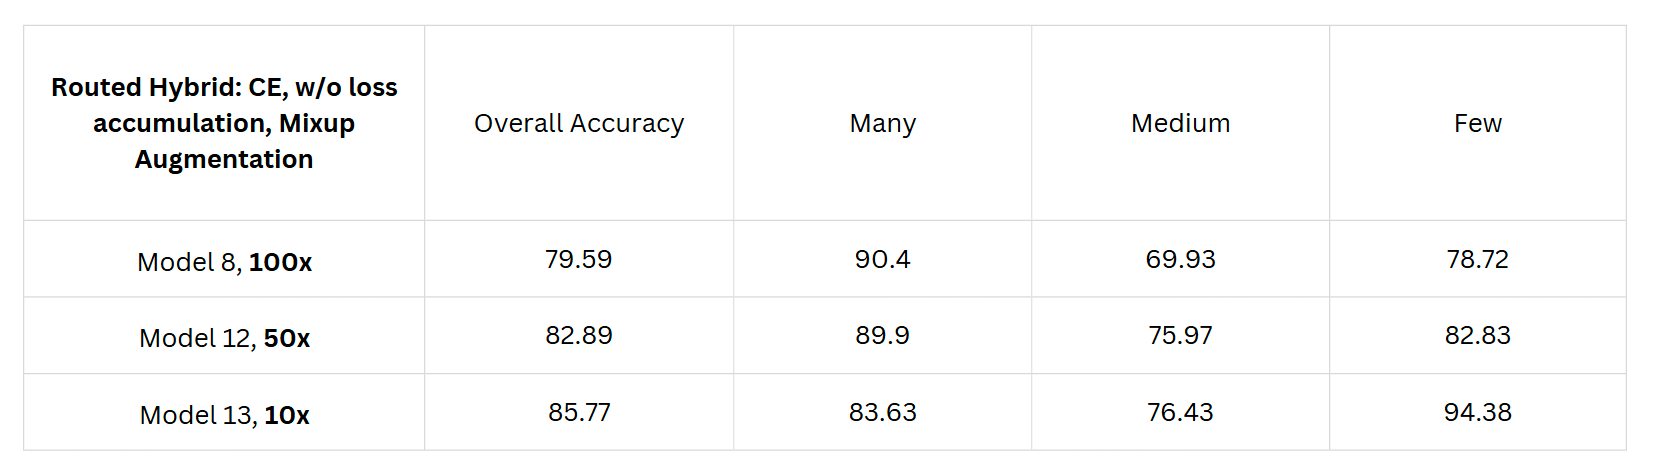

This yielded me the second highest accuracy of all the models that were executed.